In [ ]:
%reset

In [ ]:
pip install pyts matplotlib 

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import class_weight

import statistics 

import matplotlib.pyplot as plt

import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model

from scipy.signal import savgol_filter

import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

import random
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-11-21 22:29:58.447047: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-11-21 22:29:59.851369: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-11-21 22:29:59.917688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-21 22:29:59.917750: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-21 22:29:59.931989: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-21 22:29:59.932062: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-11-21 22:29:59.938551: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [4]:
#M - months A - appliances N - num of imgs 

#file_name ="UKDALE_GAF_1h_18M9A1000N"
#file_name= "UKDALE_GAF_1h_12M10A300N"
#file_name = "UKDALE_GAF_1h_12M10A500N"
#file_name = "UK-DALE_GADF_60m_300S0X_9A5000N_NmB" # x is n of paralel imgs


#file_name = "test_REFIT+ECO+UKDALE+IAWE_GASF_13m100S10X"
#file_name = "ALL_13m_100S5X-AVG-Y"
file_name ="ALL_13m_130S5X_RECU_AVG-N"
#file_name ="ALL_13m_100S5X_GDAF_AVG-Y"
file_name ="ALL_13m_100S5X_GSAF_AVG-Y"


#file_name = "iawe_H_RECU_13m_100S5X_6A5000N_AB_N-O_Y-S_AVG-N"
dir_path =os.path.abspath(os.getcwd())

#check if we are in cloud or in PC<

try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS_UNZIPPED/"f"{file_name}"
    #path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS/old2/"
except:
    print("reading from HDD")
    path = dir_path+"/data"

#check if file exists
try:
    file = h5py.File(f"{path}""/"f"{file_name}""/"f"{file_name}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


# function to make reading easier
def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.
    """
    images = []

    # Open the HDF5 file
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

reading from HDD
file exists, reading it...


In [5]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()

In [6]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [7]:
def LSTM_3D_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [8]:
def LSTM_3D_32_LSTM_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [9]:
def LSTM_3D_V42(X_train, num_classes, lr = 0.0001):
    #derived from LSTM_3D_32_LSTM_32
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [10]:
def LSTM_3D_V43(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [11]:
def LSTM_3D_V44(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [12]:
def LSTM_3D_V51(X_train, num_classes, lr = 0.0001):
    #joined v44 and v42
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [13]:
def LSTM_3D_V56(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [14]:
def LSTM_3D_V57(X_train, num_classes, lr = 0.0001):
    #joined v44 and v42
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [15]:
def LSTM_3D_V61(X_train, num_classes, lr = 0.0001):
    #FROM V56, REMOVED DROPOUT
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [16]:
def LSTM_3D_V62(X_train, num_classes, lr = 0.0001):
    #FROM V56, REMOVED ALL DROPOUTS
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_sixze=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [17]:
def LSTM_3D_V63(X_train, num_classes, lr = 0.0001):
    #FROM V56, ONE MORE CONV LAYER
    input_a = Input(shape = X_train.shape[1: ])
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [18]:
def LSTM_3D_V64(X_train, num_classes, lr = 0.0001):
    # REMOVED DROPOUT copy of V63 #best model for TL
    input_a = Input(shape = X_train.shape[1: ])
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [19]:
def LSTM_3D_V71(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    #x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x) change
    x = Dropout(0.10)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [20]:
def LSTM_3D_V72(X_train, num_classes, lr = 0.0001):
   
    input_a = Input(shape = X_train.shape[1: ])
#     x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(input_a)
#     x = TimeDistributed(Convolution2D(64, (7, 7), activation='relu', padding='same'))(x)
#     x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x) change 
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    #x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [21]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    
    
    
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [22]:
#appliance_set = set()
appliance_instances = {}
all_appliances = []
datasets = ["eco"]
appliances_len = {}

for dataset in datasets:
      
    for appliance in file[dataset].keys():

        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
            all_appliances.append(appliance)
            #appliance_set.add(appliance)
            
            samples = file[f"{dataset}""/"f"{appliance}""/"f"{building}""/gaf"].shape[0]
            
            if appliance in appliances_len:
                appliances_len[appliance].append(samples)#appliances_len[appliance] = appliances_len[appliance]+samples
            else:
                appliances_len[appliance] = [samples]
             
#available_appliances = list(appliance_set)
available_appliances_arr, instances = np.unique(all_appliances,return_counts=True)
available_appliances = list(available_appliances_arr)
for i,appliance in enumerate(available_appliances):
    appliance_instances[appliance] = instances[i]
    
print("available",available_appliances)
print("lengts",appliances_len)
print("instances",appliance_instances)

available ['HTPC', 'air handling unit', 'audio system', 'broadband router', 'coffee maker', 'computer', 'dish washer', 'freezer', 'fridge', 'garden sprinkler', 'kettle', 'lamp', 'laptop computer', 'microwave', 'washing machine']
lengts {'HTPC': [1323, 39, 857, 468, 3177], 'air handling unit': [5], 'audio system': [1380], 'broadband router': [1571], 'coffee maker': [37, 2, 39, 248], 'computer': [243, 16, 3938], 'dish washer': [62], 'freezer': [3568, 3905, 605, 3140], 'fridge': [881, 2793, 113, 404, 1628, 2427], 'garden sprinkler': [140], 'kettle': [357, 270, 24, 2, 79], 'lamp': [398, 652, 28], 'laptop computer': [635, 1733, 201], 'microwave': [592, 76], 'washing machine': [236]}
instances {'HTPC': 5, 'air handling unit': 1, 'audio system': 1, 'broadband router': 1, 'coffee maker': 4, 'computer': 3, 'dish washer': 1, 'freezer': 4, 'fridge': 6, 'garden sprinkler': 1, 'kettle': 5, 'lamp': 3, 'laptop computer': 3, 'microwave': 2, 'washing machine': 1}


In [25]:
sum_all = 0 
N = 2000
for e in appliances_len:
    print(e,appliances_len[e],sum(appliances_len[e]),"avg:",int(statistics.mean(appliances_len[e])))
    sum_all += sum(appliances_len[e])
print("num of samples: ",sum_all)

HTPC [1323, 39, 857, 468, 3177] 5864 avg: 1172
air handling unit [5] 5 avg: 5
audio system [1380] 1380 avg: 1380
broadband router [1571] 1571 avg: 1571
coffee maker [37, 2, 39, 248] 326 avg: 81
computer [243, 16, 3938] 4197 avg: 1399
dish washer [62] 62 avg: 62
freezer [3568, 3905, 605, 3140] 11218 avg: 2804
fridge [881, 2793, 113, 404, 1628, 2427] 8246 avg: 1374
garden sprinkler [140] 140 avg: 140
kettle [357, 270, 24, 2, 79] 732 avg: 146
lamp [398, 652, 28] 1078 avg: 359
laptop computer [635, 1733, 201] 2569 avg: 856
microwave [592, 76] 668 avg: 334
washing machine [236] 236 avg: 236
num of samples:  38292


In [24]:
statistics.mean(appliances_len["toaster"])

1097

In [24]:
#refit
available_appliances.remove("fridge freezer")
available_appliances.remove("fan")
available_appliances.remove("toaster")


ValueError: list.remove(x): x not in list

In [23]:
#for refit

HEKA = ["toaster","kettle"]
FF = ["fridge","fridge freezer"]
grouped_appliances = {
    
    "HEKA":HEKA,
    "fridge/freezer":FF,
    
} 
#not enough data for this appliance

available_appliances.remove("fan")
available_appliances.remove("games console")
available_appliances.remove("unknown")
available_appliances.remove("appliance")

# #new group
available_appliances.remove("fridge")
available_appliances.remove("fridge freezer")

#new group
available_appliances.remove("toaster")
available_appliances.remove("kettle")

##radndom out
#available_appliances.remove("computer")
available_appliances.remove("microwave")
#available_appliances.remove("washer dryer")

#available_appliances.remove("washing machine")
#available_appliances.remove("microwave")
#available_appliances.remove("microwave")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]

In [26]:
#redd
HEKA = []
FF = ["fridge"]
grouped_appliances = {"fridge/freezer":FF}
available_appliances.remove("electric stove")
available_appliances.remove("washer dryer")
available_appliances.remove("dish washer")
available_appliances.remove("electric oven")
available_appliances.remove("air conditioner")
available_appliances.remove("air handling unit")
available_appliances.remove("electric space heater")
available_appliances.remove("fridge")
for a in available_appliances:
    grouped_appliances[a] = [a]

ValueError: list.remove(x): x not in list

In [27]:
#iawe
grouped_appliances = {} 
available_appliances.remove("washing machine")

for a in available_appliances:
    grouped_appliances[a] = [a]

In [23]:
#for eco

HEKA = ["kettle"]
FF = ["fridge","freezer"]
grouped_appliances = {
    
    "HEKA":HEKA,
    "fridge/freezer":FF,
    
} 
#not enough data for this appliance
available_appliances.remove("garden sprinkler")

available_appliances.remove("air handling unit")
available_appliances.remove("dish washer")
# #new group
available_appliances.remove("fridge")
available_appliances.remove("freezer")

#new group

available_appliances.remove("kettle")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]

In [23]:
#ukdale
available_appliances.remove("washing machine")
#available_appliances.remove("server computer")
available_appliances.remove("freezer")
available_appliances.remove("fridge freezer")

#for one case only
available_appliances.remove("dish washer")
#available_appliances.remove("kettle")

In [19]:
available_appliances

['audio system',
 'breadmaker',
 'broadband router',
 'computer',
 'dehumidifier',
 'dish washer',
 'electric space heater',
 'food processor',
 'microwave',
 'pond pump',
 'television',
 'tumble dryer',
 'washer dryer',
 'washing machine']

In [23]:
#for ukdale

HEKA = ["toaster","kettle"]
FF = ["fridge","freezer","fridge freezer"]
grouped_appliances = {
    
    "HEKA":HEKA,
    "fridge/freezer":FF,
    
} 
#not enough data for this appliance
available_appliances.remove("washing machine")
available_appliances.remove("dish washer")


# #new group
available_appliances.remove("fridge")
available_appliances.remove("freezer")
available_appliances.remove("fridge freezer")

#new group
available_appliances.remove("toaster")
available_appliances.remove("kettle")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]



In [24]:
sum(list(grouped_appliances.values()),[])
    

['toaster',
 'kettle',
 'fridge',
 'freezer',
 'fridge freezer',
 'HTPC',
 'boiler',
 'computer monitor',
 'desktop computer',
 'laptop computer',
 'light',
 'microwave',
 'server computer',
 'television',
 'washer dryer']

In [25]:
grouped_appliances 

{'HEKA': ['toaster', 'kettle'],
 'fridge/freezer': ['fridge', 'freezer', 'fridge freezer'],
 'HTPC': ['HTPC'],
 'boiler': ['boiler'],
 'computer monitor': ['computer monitor'],
 'desktop computer': ['desktop computer'],
 'laptop computer': ['laptop computer'],
 'light': ['light'],
 'microwave': ['microwave'],
 'server computer': ['server computer'],
 'television': ['television'],
 'washer dryer': ['washer dryer']}

In [24]:
##load datasset for normal use
N_wanted = 3000
fshrt = file[f"{dataset}""/"f"{appliance}""/"f"{building}""/gaf"].shape
data = np.empty([0,fshrt[1],fshrt[2],fshrt[3],fshrt[4]])

labels = np.empty(0)
labels_ds = np.empty(0)

#datasets = ["eco"]
#datasets = ["eco","refit","ukdale", "iawe","redd"]
#datasets = ["refit","ukdale"]
appliances = []
num_of_buildings_arr = []
#for refit and eco
#appliances =  ['dish washer', 'fridge', 'fridge freezer', 'kettle',
#'microwave', 'television', 'toaster', 'washing machine', 'coffee maker',
#'computer', 'freezer', 'lamp', 'laptop computer']

#appliances = ['coffee maker', 'computer', 'freezer', 'fridge', 'lamp', 'laptop computer', 'dish washer', 'fridge freezer', 'kettle', 'microwave', 'television', 'toaster', 'washing machine', 'boiler', 'computer monitor', 'washer dryer']


#refit to train on 
#appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer"]
#datasets = ["eco","iawe","ukdale","redd"]

#eco to TL on
#datasets = ["eco"]
#appliances =["fridge","HTPC","kettle","laptop computer","coffee maker","lamp","computer","microwave"]


 #iawe to TL on
#datasets = ["iawe"]
#appliances = ["air conditioner","computer","fridge","television"]


# #redd to TL on 
#datasets = ["redd"]
#appliances = ["light","electric furnace","fridge","microwave"]


#datasets = ["ukdale"]
#appliances = ["light","laptop computer","computer monitor","desktop computer","television","dish washer","boiler","toaster","microwave","kettle"]
#'desktop computer',,, 'air conditioner', washer, dryer
# #appliances = [
#  'fridge',
#  'light',
#  'microwave']

faulty_redd_appliances = []#["air conditioner","washer dryer"]

#appliances = available_appliances 
appliances = list(grouped_appliances)

counter1 = 0
last_appliance1 = 0
counter2 = 0
last_appliance2 = 0

for dataset in datasets:
  #check last len so that number of appliances is balanced
  
    for appliance in file[dataset].keys():
    
        #train on all available appliances from refit change for test
        if appliance in sum(list(grouped_appliances.values()),[]):
            
            index = None
            for i,e in enumerate(list(grouped_appliances.values())):
                if appliance in e:
                #print("ok",i)
                    index = i
    
            grouped_appliance = list(grouped_appliances.keys())[index]
                
            
            #num_of_buildings = 0
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
              #num_of_buidlings += 1

                   

                    if dataset == "redd" and appliance in faulty_redd_appliances:
                            continue        
                    else:

                        N  = 1000
                        if appliance == "computer":
                            N = 500
                          #   N = 250 #for training
                         #N = -1
                        if appliance == "fridge" or appliance == "fridge"  :
                            N = 250 #for traingig
                         # N = -1

                        if appliance == "television":
                        #    N = 70 #for training
                            #N = 130
                            N = 300
                        if appliance == "washing machine":
                            #N = 70 #for training
    #                         N = 600
                            N = 300
                        if appliance == "washer dryer":
                            #N = 40
                             N = -1
                        if appliance == "microwave":
                            N = 250
                            #N = 90
                        if appliance == "toaster":
                            N = -1
                            N = 200
                        if appliance == "kettle":
                            N = 200
                            #N = 90
#                         if appliance == "microwave":
#                             N = -1
#                         if appliance == "HTPC":
#                             N = -1
                        #N = 1500
                        #N = 3000
                        N=2500
#                         if appliance == "desktop computer":
#                             #N = 654 #for 1000
#                              N = 854
                        
                        #current number of samples
        
                        #N = int(N_wanted/len(appliances_len[appliance]))
                        
                        if appliance in HEKA:
                            
                            if appliance != last_appliance1:
                                counter1 += 1
                            last_appliance1 = appliance
                            N = int(N/len(HEKA))*counter1
                        
                        if appliance in FF:
                            
                            if appliance != last_appliance2:
                                counter2 += 1
                            last_appliance2 = appliance
                            N = int(N/len(FF))*counter2
                            
                        appl_sample_len = len(np.where(labels == list(grouped_appliances.keys()).index(grouped_appliance))[0])
                        N = N - appl_sample_len
                        if appl_sample_len  > N_wanted:#1900:
                            print("skiping.. max len exeeded",appliance,building,appl_sample_len)
                            continue
                    
                        #images = np.array()

                        images = file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'][0:N,...]
                        #images = images[N+1:-1,...]

                        data = np.append(data,images,axis=0)

                        array_of_labels = np.ones(images.shape[0])*list(grouped_appliances.keys()).index(grouped_appliance)
                        labels = np.append(labels,array_of_labels)

                        array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                        labels_ds = np.append(labels_ds,array_of_labels_ds)

                        #array_of_labels_buildings = np.ones(images.shape[0])*datasets.index(dataset)
                        #labels_buildings = 

                        print("dataset",dataset,"app",appliance,"bui",building,"curr data",images.shape[0],"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)
#                 else:
#                     print("skipped appl: ",appliance," group ",list(grouped_appliances.keys()).index(appliance)," and dataset:",dataset," due to len: ",(len(np.where(labels == appliances.index(appliance))[0]) - last_length))
        

print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

dataset eco app HTPC bui 2 curr data 1323 shape (1323, 5, 100, 100, 1) labels (1323,) dsshape (1323,)
dataset eco app HTPC bui 3 curr data 39 shape (1362, 5, 100, 100, 1) labels (1362,) dsshape (1362,)
dataset eco app HTPC bui 4 curr data 857 shape (2219, 5, 100, 100, 1) labels (2219,) dsshape (2219,)
dataset eco app HTPC bui 5 curr data 281 shape (2500, 5, 100, 100, 1) labels (2500,) dsshape (2500,)
dataset eco app HTPC bui 6 curr data 0 shape (2500, 5, 100, 100, 1) labels (2500,) dsshape (2500,)
dataset eco app audio system bui 2 curr data 1380 shape (3880, 5, 100, 100, 1) labels (3880,) dsshape (3880,)
dataset eco app broadband router bui 6 curr data 1571 shape (5451, 5, 100, 100, 1) labels (5451,) dsshape (5451,)
dataset eco app coffee maker bui 1 curr data 37 shape (5488, 5, 100, 100, 1) labels (5488,) dsshape (5488,)
dataset eco app coffee maker bui 3 curr data 2 shape (5490, 5, 100, 100, 1) labels (5490,) dsshape (5490,)
dataset eco app coffee maker bui 5 curr data 39 shape (552

In [31]:
sum_all = 0
for i in range(len(appliances)):
  print(appliances[i],len(np.where(labels == i)[0]) )
  sum_all += len(np.where(labels == i)[0])
print("number of samples:",sum_all)

HEKA 732
fridge/freezer 3500
HTPC 3500
audio system 1380
broadband router 1571
coffee maker 326
computer 3500
lamp 1078
laptop computer 2569
microwave 668
washing machine 236
number of samples: 19060


In [29]:
data = 0

In [25]:
#Convert classes to onehot encoding

# manualy_selected_appliances= ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
num_of_classes = len(appliances)  # 
print(appliances)
print(num_of_classes)

y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

y_integers = np.argmax(y_anomF, axis=1)
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes = np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
11
{0: 1.985966219572777, 1: 0.5814909090909091, 2: 0.5814909090909091, 3: 1.053425559947299, 4: 0.9253515421561253, 5: 4.459286112660346, 6: 0.5814909090909091, 7: 1.3485410693202902, 8: 0.5814909090909091, 9: 2.176238432226456, 10: 6.159861325115562}


In [33]:
#Split data on training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_train[0]
data = 0;

(15248, 5, 100, 100, 1)
(15248, 11)
(3812, 5, 100, 100, 1)
(3812, 11)


In [ ]:
#copy model for refrence later 
model_copy= keras.models.clone_model(model)
model_copy.build((None, X_train.shape[1: ])) # replace 10 with number of variables in input layer
lr = 0.00002
adam = optimizers.Adam(lr = lr)
model_copy.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_copy.set_weights(model.get_weights())

RECU ukdale


In [26]:
#path_model = dir_path+"/models/auto_classic3/model_1"

path_model = dir_path+"/models/refit/GSAF/LSTM3DV56/model2"

#path_model = dir_path+"/models/auto_classic6/model_0"
#path_model = dir_path+"/models/gen/model_gen"
model = keras.models.load_model(path_model)

2021-11-21 22:31:01.427801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-21 22:31:01.428616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-11-21 22:31:01.428933: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-21 22:31:02.317169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-21 22:31:02.317233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-21 22:31:02.317258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-21 22:31:02.318469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

In [28]:
model_used = model

In [37]:
#create trasfer learning model 
model.trainable = False
base_output = model.layers[-2].output
hidden4 = Dense(64, activation='relu')(base_output)
hidden3 = Dense(32, activation='relu')(hidden4)
hidden2 = Dense(16, activation='relu')(hidden3)
hidden = Dense(num_of_classes, activation='softmax')(hidden2)

model2 = keras.models.Model(model.inputs, hidden)
lr = 0.002
adam = optimizers.Adam(lr = lr)
model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [35]:
## Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
model = LSTM_3D(X_train,num_of_classes,lr = 0.00002) #00
model = LSTM_3D_V56(X_train,num_of_classes,lr = 0.00002) #00
#tf.keras.backend.clear_session()model = LSTM_3D_32_LSTM_dropout(X_train,num_of_classes,lr = 0.00002) #00

2021-11-21 22:03:05.555708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-21 22:03:05.556957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-11-21 22:03:05.557278: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-21 22:03:06.417249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-21 22:03:06.417285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-21 22:03:06.417292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-21 22:03:06.418459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

In [32]:
model_used = model2

model_used.fit(X_train, y_train, batch_size = 8, epochs = 30, verbose = 2,class_weight=d_class_weights,callbacks=ClearMemory())
#model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 100, verbose = 2,callbacks=ClearMemory())


results = model_used.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30


2021-11-19 17:49:27.263269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-19 17:49:27.284363: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2021-11-19 17:49:29.284188: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-19 17:49:30.065837: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-19 17:49:30.950583: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-19 17:49:31.738094: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


3716/3716 - 33s - loss: 0.7760 - accuracy: 0.7230
Epoch 2/30
3716/3716 - 28s - loss: 0.6162 - accuracy: 0.7774
Epoch 3/30
3716/3716 - 28s - loss: 0.5978 - accuracy: 0.7813
Epoch 4/30
3716/3716 - 28s - loss: 0.5775 - accuracy: 0.7903
Epoch 5/30
3716/3716 - 28s - loss: 0.5573 - accuracy: 0.7971
Epoch 6/30
3716/3716 - 28s - loss: 0.5459 - accuracy: 0.8003
Epoch 7/30
3716/3716 - 28s - loss: 0.5452 - accuracy: 0.8010
Epoch 8/30
3716/3716 - 28s - loss: 0.5410 - accuracy: 0.7993
Epoch 9/30
3716/3716 - 28s - loss: 0.5312 - accuracy: 0.8060
Epoch 10/30
3716/3716 - 28s - loss: 0.5335 - accuracy: 0.8064
Epoch 11/30
3716/3716 - 28s - loss: 0.5267 - accuracy: 0.8101
Epoch 12/30
3716/3716 - 28s - loss: 0.5190 - accuracy: 0.8095
Epoch 13/30
3716/3716 - 28s - loss: 0.5184 - accuracy: 0.8081
Epoch 14/30
3716/3716 - 28s - loss: 0.5156 - accuracy: 0.8134
Epoch 15/30
3716/3716 - 28s - loss: 0.5114 - accuracy: 0.8125
Epoch 16/30
3716/3716 - 28s - loss: 0.5080 - accuracy: 0.8169
Epoch 17/30
3716/3716 - 28s 

In [32]:
trs_type = file_name.split("_")[3]
path_model_classic = dir_path+"/models/"+datasets[0]+"/"+trs_type+"/LSTM3DV56/model2"
#model_used.save(path_model_classic)

2021-11-19 17:30:22.669146: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/GSAF/LSTM3DV56/model2/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/GSAF/LSTM3DV56/model2/assets


In [38]:
d

233/233 - 4s
[[476   0   0   0   0   0   0   0 184   0   0   0]
 [  0 600   4   9  32   0   0   8   0   6   1   0]
 [  0   2 457   4  61  19   4   1   0  46   6   0]
 [  0   9   1 615  10   1  10   0   0   7   6   1]
 [  0  42  67   3 525   1   1   2   0   7  12   0]
 [  0   0   5   8  11 491  14  28   1  76  26   0]
 [  0   1   1  11  10  14 622   0   0   1   0   0]
 [  0  15   5   4   5  30   0 477   5  15  39   5]
 [ 28   0   0   0   0   0   0   3 629   0   0   0]
 [  0   0   4   5   2  10   0  10   0 365   1   0]
 [  0   1  19   8  14  22   6  23   0  12 551   4]
 [  0   0   0   0   0  21   5  24   0   0  30 474]]
F1 SCORE 0.8435766125206984
Normalized confusion matrix
                  precision    recall  f1-score   support

            HEKA       0.94      0.72      0.82       660
  fridge/freezer       0.90      0.91      0.90       660
            HTPC       0.81      0.76      0.79       600
          boiler       0.92      0.93      0.93       660
computer monitor       0.78

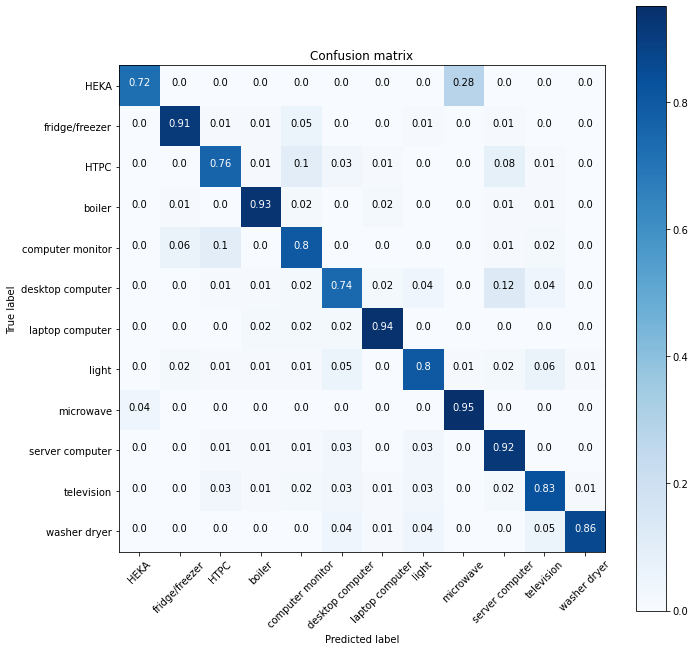

In [33]:
#Print results and plot confusion matrix

#print('Test accuracy: ', results[1])
#print("Loss: "f"{results[0]}")
Y_pred = model_used.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
C = confusion_matrix(Y_test, y_pred)
# B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
print(confusion_matrix(Y_test, y_pred))
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
print("F1 SCORE",fscore)
plot_confusion_matrix_norm(C, appliances, normalize=True)
print(classification_report(Y_test, y_pred, target_names=appliances))

In [52]:
for dataset in datasets_test:
    print(dataset[1])

model_0
model_1
model_3
model_1
model_6
model_1
model_2
model_3
model_4


In [ ]:
datasets_test = ["auto_classic6"]
models_test = ["model_0","model_2","model_3","model_4"]

#datasets_test = [
#                 ["randomOut","modelM1"],
#                 ["randomOut","model0"],
#                 ["randomOut","model1"],
#                 ["randomOut","model2"],
#                 ["randomOut","model3"],
#                 ["randomOut","model4"],
#                 ["randomOut","model5"],
#                 ["randomOut","model6"],
#                 ["randomOut","model7"],
#                 ["randomOut","model8"],
#                 ["randomOut","model9"],
#                 ["randomOut","model10"],
#                 ["randomOut","model11"],
#                 ["randomOut","model12"],
#                 ["randomOut","model13"],
#                ]

datasets_test = [
                 ["LSTM3D","model1"],
                 ["LSTM3D","model2"],
                 ["LSTM3DV56","model1"],
                 ["LSTM3DV56","model2"],
                ]

acc_a = []
loss_a = []
f1_a = []
precision_a = []
recall_a = []
number_apl_a = []
count = 1
#models_test = ["model_0","model_1","model_2","model_3","model_4"]
for dataset in datasets_test:
    #for model in models_test:
        
        
        print("testing dataset ",dataset[0],"model ", dataset[1])
        path_model = dir_path+"/models/refit/GDAF/"+dataset[0]+"/"+dataset[1]#+"/model1"
        
        #print("testing dataset ",dataset ,"model ", model)
        #path_model = dir_path+"/models/"+dataset+"/"+model



        #path_model = dir_path+"/models/model_classic3"
        #path_model = dir_path+"/models/gen/model_gen"
        try:
            model = keras.models.load_model(path_model)
            print("model exist, reading is done!")
        except:
            print("model does not exist")
            continue

        #create trasfer learning model 
        model.trainable = False
        base_output = model.layers[-2].output
        #hidden6 = Dense(2000, activation='relu')(base_output)
        #hidden5 = Dense(300, activation='relu')(hidden6)
        hidden4 = Dense(64, activation='relu')(base_output)
        hidden3 = Dense(32, activation='relu')(hidden4)
        hidden2 = Dense(16, activation='relu')(hidden3)
        hidden = Dense(num_of_classes, activation='softmax')(hidden2)

        model2 = keras.models.Model(model.inputs, hidden)
        lr = 0.002
        adam = optimizers.Adam(lr = lr)
        model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

        #trian
        model_used = model2

        model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 100, verbose = 2,callbacks=ClearMemory())
        results = model_used.evaluate(X_test, y_test, verbose = 2)
        print('Test accuracy: ', results[1])

        #Print results and plot confusion matrix

        #print('Test accuracy: ', results[1])
        #print("Loss: "f"{results[0]}")
        Y_pred = model_used.predict(X_test, verbose = 2)
        y_pred = np.argmax(Y_pred, axis=1)
        Y_test = np.argmax(y_test, axis=-1)
        C = confusion_matrix(Y_test, y_pred)
        # B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)

        print(confusion_matrix(Y_test, y_pred))
        precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
        print("F1 SCORE",fscore)
        plot_confusion_matrix_norm(C, appliances, normalize=True)
        print(classification_report(Y_test, y_pred, target_names=appliances))
        
        
        f1_a.append(round(fscore,4))
        acc_a.append(round(results[1] * 100,4))
        loss_a.append(round(results[0],4))
        precision_a.append(round(precision,4))
        recall_a.append(round(recall,4))
        count = count +1
        number_apl_a.append(count)
        print('Test accuracy: ',acc_a[-1])
        print('Test loss: ',loss_a[-1])
        print('test f1: ',f1_a[-1])
        del model_used
        del model
        del model2

testing dataset  LSTM3D model  model1


2021-11-18 09:31:12.537987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-18 09:31:12.539155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-11-18 09:31:12.542034: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-18 09:31:13.448704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-18 09:31:13.448739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-18 09:31:13.448933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-18 09:31:13.450375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

model exist, reading is done!


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-18 09:31:19.288954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-18 09:31:19.312352: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/30


2021-11-18 09:31:20.364276: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-18 09:31:21.118876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-18 09:31:22.023696: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-18 09:31:22.841053: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2990/2990 - 26s - loss: 1.0696 - accuracy: 0.6095 - val_loss: 0.9313 - val_accuracy: 0.6538
Epoch 2/30
2990/2990 - 21s - loss: 0.9383 - accuracy: 0.6566 - val_loss: 0.9221 - val_accuracy: 0.6630
Epoch 3/30
2990/2990 - 21s - loss: 0.9090 - accuracy: 0.6630 - val_loss: 0.8918 - val_accuracy: 0.6726
Epoch 4/30
2990/2990 - 21s - loss: 0.8934 - accuracy: 0.6722 - val_loss: 0.8710 - val_accuracy: 0.6883
Epoch 5/30
2990/2990 - 21s - loss: 0.8833 - accuracy: 0.6760 - val_loss: 0.8675 - val_accuracy: 0.6804
Epoch 6/30
2990/2990 - 21s - loss: 0.8668 - accuracy: 0.6807 - val_loss: 0.8764 - val_accuracy: 0.6761
Epoch 7/30
2990/2990 - 21s - loss: 0.8626 - accuracy: 0.6816 - val_loss: 0.8435 - val_accuracy: 0.6891
Epoch 8/30
2990/2990 - 21s - loss: 0.8554 - accuracy: 0.6847 - val_loss: 0.8571 - val_accuracy: 0.6943
Epoch 9/30
2990/2990 - 21s - loss: 0.8492 - accuracy: 0.6866 - val_loss: 0.8515 - val_accuracy: 0.6885
Epoch 10/30
2990/2990 - 21s - loss: 0.8461 - accuracy: 0.6880 - val_loss: 0.8605 - v

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [98]:
f1.insert(0,0.812) 

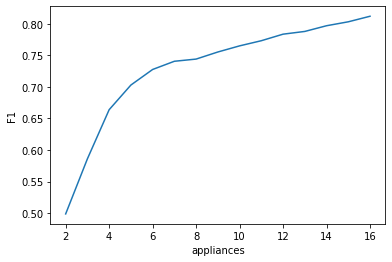

In [102]:
#plt.plot(number_apl_a[:-1],f1[:-1])
plt.plot(number_apl_a[:-1],savgol_filter(f1[:-1],3,1))
#plt.plot(number_apl_a[:-1],recall_a[:-1])
plt.ylabel("F1")
plt.xlabel("appliances")
plt.show()

In [38]:
np.unique(labels)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [27]:
#kfold with random seed
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
seed_per_fold = []

for seed in range(10,1200,50):
    print("using seed:",seed)

    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=seed, stratify=y_anomF)
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden4 = Dense(64, activation='relu')(base_output)
    hidden3 = Dense(32, activation='relu')(hidden4)
    hidden2 = Dense(16, activation='relu')(hidden3)
    hidden = Dense(num_of_classes, activation='softmax')(hidden2)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.002
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    #model = LSTM_3D_V56(X_train,num_of_classes,lr = 0.00002) #00
    model_used = model2
    #print(model.summary())
    #model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model_used.fit(X_train, y_train, batch_size = 8, epochs = 30, verbose = 2,class_weight=d_class_weights,callbacks=ClearMemory())

    results = model_used.evaluate(X_test, y_test, verbose = 2)
    
    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    precision_per_fold.append(round(precision,4))
    recall_per_fold.append(round(recall,4))
    seed_per_fold.append(seed)


    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    print('test f1: ',f1_per_fold[-1])

using seed: 10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30


2021-11-21 22:31:09.178295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-21 22:31:09.200234: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2021-11-21 22:31:10.940560: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-21 22:31:11.696969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-21 22:31:12.614015: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-21 22:31:13.423917: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1599/1599 - 16s - loss: 0.9614 - accuracy: 0.6040
Epoch 2/30
1599/1599 - 11s - loss: 0.7275 - accuracy: 0.6855
Epoch 3/30
1599/1599 - 11s - loss: 0.6833 - accuracy: 0.7045
Epoch 4/30
1599/1599 - 11s - loss: 0.6703 - accuracy: 0.7036
Epoch 5/30
1599/1599 - 11s - loss: 0.6445 - accuracy: 0.7201
Epoch 6/30
1599/1599 - 11s - loss: 0.6166 - accuracy: 0.7269
Epoch 7/30
1599/1599 - 11s - loss: 0.6143 - accuracy: 0.7314
Epoch 8/30
1599/1599 - 11s - loss: 0.6151 - accuracy: 0.7302
Epoch 9/30
1599/1599 - 11s - loss: 0.6125 - accuracy: 0.7325
Epoch 10/30
1599/1599 - 11s - loss: 0.6011 - accuracy: 0.7343
Epoch 11/30
1599/1599 - 11s - loss: 0.5964 - accuracy: 0.7321
Epoch 12/30
1599/1599 - 11s - loss: 0.5905 - accuracy: 0.7324
Epoch 13/30
1599/1599 - 11s - loss: 0.5730 - accuracy: 0.7350
Epoch 14/30
1599/1599 - 11s - loss: 0.5768 - accuracy: 0.7429
Epoch 15/30
1599/1599 - 11s - loss: 0.5847 - accuracy: 0.7363
Epoch 16/30
1599/1599 - 11s - loss: 0.5693 - accuracy: 0.7458
Epoch 17/30
1599/1599 - 11s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9808 - accuracy: 0.5980
Epoch 2/30
1599/1599 - 11s - loss: 0.7344 - accuracy: 0.6843
Epoch 3/30
1599/1599 - 11s - loss: 0.6782 - accuracy: 0.7050
Epoch 4/30
1599/1599 - 11s - loss: 0.6540 - accuracy: 0.7182
Epoch 5/30
1599/1599 - 11s - loss: 0.6432 - accuracy: 0.7157
Epoch 6/30
1599/1599 - 11s - loss: 0.6211 - accuracy: 0.7233
Epoch 7/30
1599/1599 - 11s - loss: 0.6122 - accuracy: 0.7276
Epoch 8/30
1599/1599 - 11s - loss: 0.6129 - accuracy: 0.7262
Epoch 9/30
1599/1599 - 11s - loss: 0.6035 - accuracy: 0.7351
Epoch 10/30
1599/1599 - 11s - loss: 0.5978 - accuracy: 0.7369
Epoch 11/30
1599/1599 - 11s - loss: 0.5935 - accuracy: 0.7391
Epoch 12/30
1599/1599 - 11s - loss: 0.5917 - accuracy: 0.7415
Epoch 13/30
1599/1599 - 11s - loss: 0.5850 - accuracy: 0.7416
Epoch 14/30
1599/1599 - 11s - loss: 0.5754 - accuracy: 0.7433
Epoch 15/30
1599/1599 - 11s - loss: 0.5820 - accuracy: 0.7445
Epoch 16/30
1599/1599 - 11s - loss: 0.5766 - accuracy: 0.7422
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9858 - accuracy: 0.6047
Epoch 2/30
1599/1599 - 11s - loss: 0.7450 - accuracy: 0.6850
Epoch 3/30
1599/1599 - 11s - loss: 0.6959 - accuracy: 0.6981
Epoch 4/30
1599/1599 - 11s - loss: 0.6582 - accuracy: 0.7107
Epoch 5/30
1599/1599 - 11s - loss: 0.6453 - accuracy: 0.7146
Epoch 6/30
1599/1599 - 11s - loss: 0.6435 - accuracy: 0.7172
Epoch 7/30
1599/1599 - 11s - loss: 0.6350 - accuracy: 0.7246
Epoch 8/30
1599/1599 - 11s - loss: 0.6159 - accuracy: 0.7263
Epoch 9/30
1599/1599 - 11s - loss: 0.6022 - accuracy: 0.7354
Epoch 10/30
1599/1599 - 11s - loss: 0.5987 - accuracy: 0.7316
Epoch 11/30
1599/1599 - 11s - loss: 0.5956 - accuracy: 0.7352
Epoch 12/30
1599/1599 - 11s - loss: 0.5930 - accuracy: 0.7424
Epoch 13/30
1599/1599 - 11s - loss: 0.5882 - accuracy: 0.7384
Epoch 14/30
1599/1599 - 11s - loss: 0.5911 - accuracy: 0.7378
Epoch 15/30
1599/1599 - 11s - loss: 0.5814 - accuracy: 0.7373
Epoch 16/30
1599/1599 - 11s - loss: 0.5779 - accuracy: 0.7441
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9762 - accuracy: 0.6032
Epoch 2/30
1599/1599 - 11s - loss: 0.7330 - accuracy: 0.6804
Epoch 3/30
1599/1599 - 11s - loss: 0.6975 - accuracy: 0.6996
Epoch 4/30
1599/1599 - 11s - loss: 0.6590 - accuracy: 0.7105
Epoch 5/30
1599/1599 - 11s - loss: 0.6441 - accuracy: 0.7184
Epoch 6/30
1599/1599 - 11s - loss: 0.6465 - accuracy: 0.7167
Epoch 7/30
1599/1599 - 11s - loss: 0.6152 - accuracy: 0.7277
Epoch 8/30
1599/1599 - 11s - loss: 0.6286 - accuracy: 0.7242
Epoch 9/30
1599/1599 - 11s - loss: 0.6018 - accuracy: 0.7362
Epoch 10/30
1599/1599 - 11s - loss: 0.5996 - accuracy: 0.7419
Epoch 11/30
1599/1599 - 11s - loss: 0.6031 - accuracy: 0.7337
Epoch 12/30
1599/1599 - 11s - loss: 0.5951 - accuracy: 0.7383
Epoch 13/30
1599/1599 - 11s - loss: 0.5808 - accuracy: 0.7407
Epoch 14/30
1599/1599 - 11s - loss: 0.5858 - accuracy: 0.7419
Epoch 15/30
1599/1599 - 11s - loss: 0.5765 - accuracy: 0.7405
Epoch 16/30
1599/1599 - 11s - loss: 0.5885 - accuracy: 0.7388
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9945 - accuracy: 0.6025
Epoch 2/30
1599/1599 - 11s - loss: 0.7376 - accuracy: 0.6836
Epoch 3/30
1599/1599 - 11s - loss: 0.6887 - accuracy: 0.7019
Epoch 4/30
1599/1599 - 11s - loss: 0.6559 - accuracy: 0.7137
Epoch 5/30
1599/1599 - 11s - loss: 0.6482 - accuracy: 0.7147
Epoch 6/30
1599/1599 - 11s - loss: 0.6373 - accuracy: 0.7219
Epoch 7/30
1599/1599 - 11s - loss: 0.6221 - accuracy: 0.7262
Epoch 8/30
1599/1599 - 11s - loss: 0.6146 - accuracy: 0.7308
Epoch 9/30
1599/1599 - 11s - loss: 0.6166 - accuracy: 0.7306
Epoch 10/30
1599/1599 - 11s - loss: 0.6055 - accuracy: 0.7312
Epoch 11/30
1599/1599 - 11s - loss: 0.6050 - accuracy: 0.7326
Epoch 12/30
1599/1599 - 11s - loss: 0.6102 - accuracy: 0.7330
Epoch 13/30
1599/1599 - 11s - loss: 0.6005 - accuracy: 0.7352
Epoch 14/30
1599/1599 - 11s - loss: 0.5879 - accuracy: 0.7406
Epoch 15/30
1599/1599 - 11s - loss: 0.5848 - accuracy: 0.7434
Epoch 16/30
1599/1599 - 11s - loss: 0.5785 - accuracy: 0.7481
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9636 - accuracy: 0.6155
Epoch 2/30
1599/1599 - 11s - loss: 0.7399 - accuracy: 0.6846
Epoch 3/30
1599/1599 - 11s - loss: 0.6800 - accuracy: 0.6972
Epoch 4/30
1599/1599 - 11s - loss: 0.6587 - accuracy: 0.7126
Epoch 5/30
1599/1599 - 11s - loss: 0.6422 - accuracy: 0.7125
Epoch 6/30
1599/1599 - 11s - loss: 0.6254 - accuracy: 0.7198
Epoch 7/30
1599/1599 - 11s - loss: 0.6081 - accuracy: 0.7244
Epoch 8/30
1599/1599 - 11s - loss: 0.6117 - accuracy: 0.7303
Epoch 9/30
1599/1599 - 11s - loss: 0.6009 - accuracy: 0.7269
Epoch 10/30
1599/1599 - 11s - loss: 0.6017 - accuracy: 0.7330
Epoch 11/30
1599/1599 - 11s - loss: 0.5905 - accuracy: 0.7278
Epoch 12/30
1599/1599 - 11s - loss: 0.5939 - accuracy: 0.7365
Epoch 13/30
1599/1599 - 11s - loss: 0.5791 - accuracy: 0.7387
Epoch 14/30
1599/1599 - 11s - loss: 0.5916 - accuracy: 0.7335
Epoch 15/30
1599/1599 - 11s - loss: 0.5624 - accuracy: 0.7423
Epoch 16/30
1599/1599 - 11s - loss: 0.5861 - accuracy: 0.7380
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9761 - accuracy: 0.5952
Epoch 2/30
1599/1599 - 11s - loss: 0.7413 - accuracy: 0.6826
Epoch 3/30
1599/1599 - 11s - loss: 0.7110 - accuracy: 0.6978
Epoch 4/30
1599/1599 - 11s - loss: 0.6690 - accuracy: 0.7089
Epoch 5/30
1599/1599 - 11s - loss: 0.6490 - accuracy: 0.7172
Epoch 6/30
1599/1599 - 11s - loss: 0.6394 - accuracy: 0.7186
Epoch 7/30
1599/1599 - 11s - loss: 0.6228 - accuracy: 0.7244
Epoch 8/30
1599/1599 - 11s - loss: 0.6167 - accuracy: 0.7220
Epoch 9/30
1599/1599 - 11s - loss: 0.6006 - accuracy: 0.7317
Epoch 10/30
1599/1599 - 11s - loss: 0.6089 - accuracy: 0.7333
Epoch 11/30
1599/1599 - 11s - loss: 0.6014 - accuracy: 0.7348
Epoch 12/30
1599/1599 - 11s - loss: 0.5885 - accuracy: 0.7373
Epoch 13/30
1599/1599 - 11s - loss: 0.5914 - accuracy: 0.7384
Epoch 14/30
1599/1599 - 11s - loss: 0.6039 - accuracy: 0.7376
Epoch 15/30
1599/1599 - 11s - loss: 0.5877 - accuracy: 0.7373
Epoch 16/30
1599/1599 - 11s - loss: 0.5781 - accuracy: 0.7475
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9752 - accuracy: 0.6209
Epoch 2/30
1599/1599 - 11s - loss: 0.7511 - accuracy: 0.6818
Epoch 3/30
1599/1599 - 11s - loss: 0.6971 - accuracy: 0.6923
Epoch 4/30
1599/1599 - 11s - loss: 0.6669 - accuracy: 0.7075
Epoch 5/30
1599/1599 - 11s - loss: 0.6611 - accuracy: 0.7031
Epoch 6/30
1599/1599 - 11s - loss: 0.6494 - accuracy: 0.7137
Epoch 7/30
1599/1599 - 11s - loss: 0.6315 - accuracy: 0.7193
Epoch 8/30
1599/1599 - 11s - loss: 0.6185 - accuracy: 0.7284
Epoch 9/30
1599/1599 - 11s - loss: 0.6201 - accuracy: 0.7343
Epoch 10/30
1599/1599 - 11s - loss: 0.6076 - accuracy: 0.7298
Epoch 11/30
1599/1599 - 11s - loss: 0.6062 - accuracy: 0.7292
Epoch 12/30
1599/1599 - 11s - loss: 0.5967 - accuracy: 0.7346
Epoch 13/30
1599/1599 - 11s - loss: 0.6016 - accuracy: 0.7337
Epoch 14/30
1599/1599 - 11s - loss: 0.5901 - accuracy: 0.7398
Epoch 15/30
1599/1599 - 11s - loss: 0.5821 - accuracy: 0.7427
Epoch 16/30
1599/1599 - 11s - loss: 0.5887 - accuracy: 0.7425
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9737 - accuracy: 0.6030
Epoch 2/30
1599/1599 - 11s - loss: 0.7519 - accuracy: 0.6814
Epoch 3/30
1599/1599 - 11s - loss: 0.6950 - accuracy: 0.6956
Epoch 4/30
1599/1599 - 11s - loss: 0.6752 - accuracy: 0.7144
Epoch 5/30
1599/1599 - 11s - loss: 0.6680 - accuracy: 0.7076
Epoch 6/30
1599/1599 - 11s - loss: 0.6434 - accuracy: 0.7194
Epoch 7/30
1599/1599 - 11s - loss: 0.6397 - accuracy: 0.7176
Epoch 8/30
1599/1599 - 11s - loss: 0.6295 - accuracy: 0.7212
Epoch 9/30
1599/1599 - 11s - loss: 0.6166 - accuracy: 0.7265
Epoch 10/30
1599/1599 - 11s - loss: 0.6329 - accuracy: 0.7290
Epoch 11/30
1599/1599 - 11s - loss: 0.6153 - accuracy: 0.7318
Epoch 12/30
1599/1599 - 11s - loss: 0.6055 - accuracy: 0.7337
Epoch 13/30
1599/1599 - 11s - loss: 0.6028 - accuracy: 0.7371
Epoch 14/30
1599/1599 - 11s - loss: 0.5949 - accuracy: 0.7400
Epoch 15/30
1599/1599 - 11s - loss: 0.5971 - accuracy: 0.7339
Epoch 16/30
1599/1599 - 11s - loss: 0.5888 - accuracy: 0.7404
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9911 - accuracy: 0.5918
Epoch 2/30
1599/1599 - 11s - loss: 0.7440 - accuracy: 0.6840
Epoch 3/30
1599/1599 - 11s - loss: 0.7031 - accuracy: 0.6959
Epoch 4/30
1599/1599 - 11s - loss: 0.6733 - accuracy: 0.7106
Epoch 5/30
1599/1599 - 11s - loss: 0.6581 - accuracy: 0.7111
Epoch 6/30
1599/1599 - 11s - loss: 0.6334 - accuracy: 0.7262
Epoch 7/30
1599/1599 - 11s - loss: 0.6270 - accuracy: 0.7230
Epoch 8/30
1599/1599 - 11s - loss: 0.6201 - accuracy: 0.7243
Epoch 9/30
1599/1599 - 11s - loss: 0.5985 - accuracy: 0.7308
Epoch 10/30
1599/1599 - 11s - loss: 0.6087 - accuracy: 0.7349
Epoch 11/30
1599/1599 - 11s - loss: 0.6085 - accuracy: 0.7361
Epoch 12/30
1599/1599 - 11s - loss: 0.5958 - accuracy: 0.7344
Epoch 13/30
1599/1599 - 11s - loss: 0.5994 - accuracy: 0.7343
Epoch 14/30
1599/1599 - 11s - loss: 0.5847 - accuracy: 0.7451
Epoch 15/30
1599/1599 - 11s - loss: 0.5854 - accuracy: 0.7427
Epoch 16/30
1599/1599 - 11s - loss: 0.5762 - accuracy: 0.7437
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 1.0050 - accuracy: 0.5973
Epoch 2/30
1599/1599 - 11s - loss: 0.7392 - accuracy: 0.6809
Epoch 3/30
1599/1599 - 11s - loss: 0.6988 - accuracy: 0.6968
Epoch 4/30
1599/1599 - 11s - loss: 0.6761 - accuracy: 0.7048
Epoch 5/30
1599/1599 - 11s - loss: 0.6434 - accuracy: 0.7156
Epoch 6/30
1599/1599 - 11s - loss: 0.6545 - accuracy: 0.7116
Epoch 7/30
1599/1599 - 11s - loss: 0.6273 - accuracy: 0.7176
Epoch 8/30
1599/1599 - 11s - loss: 0.6201 - accuracy: 0.7290
Epoch 9/30
1599/1599 - 11s - loss: 0.6031 - accuracy: 0.7321
Epoch 10/30
1599/1599 - 11s - loss: 0.6044 - accuracy: 0.7282
Epoch 11/30
1599/1599 - 11s - loss: 0.6062 - accuracy: 0.7368
Epoch 12/30
1599/1599 - 11s - loss: 0.6032 - accuracy: 0.7308
Epoch 13/30
1599/1599 - 11s - loss: 0.5899 - accuracy: 0.7370
Epoch 14/30
1599/1599 - 11s - loss: 0.5920 - accuracy: 0.7289
Epoch 15/30
1599/1599 - 11s - loss: 0.5835 - accuracy: 0.7412
Epoch 16/30
1599/1599 - 11s - loss: 0.5715 - accuracy: 0.7428
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9746 - accuracy: 0.6138
Epoch 2/30
1599/1599 - 11s - loss: 0.7396 - accuracy: 0.6857
Epoch 3/30
1599/1599 - 11s - loss: 0.6950 - accuracy: 0.6968
Epoch 4/30
1599/1599 - 11s - loss: 0.6757 - accuracy: 0.7101
Epoch 5/30
1599/1599 - 11s - loss: 0.6454 - accuracy: 0.7171
Epoch 6/30
1599/1599 - 11s - loss: 0.6241 - accuracy: 0.7259
Epoch 7/30
1599/1599 - 11s - loss: 0.6318 - accuracy: 0.7256
Epoch 8/30
1599/1599 - 11s - loss: 0.6097 - accuracy: 0.7336
Epoch 9/30
1599/1599 - 11s - loss: 0.6091 - accuracy: 0.7342
Epoch 10/30
1599/1599 - 11s - loss: 0.5951 - accuracy: 0.7330
Epoch 11/30
1599/1599 - 11s - loss: 0.5957 - accuracy: 0.7376
Epoch 12/30
1599/1599 - 11s - loss: 0.5954 - accuracy: 0.7418
Epoch 13/30
1599/1599 - 11s - loss: 0.5841 - accuracy: 0.7366
Epoch 14/30
1599/1599 - 11s - loss: 0.6010 - accuracy: 0.7355
Epoch 15/30
1599/1599 - 11s - loss: 0.5930 - accuracy: 0.7390
Epoch 16/30
1599/1599 - 11s - loss: 0.5912 - accuracy: 0.7398
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9726 - accuracy: 0.5963
Epoch 2/30
1599/1599 - 11s - loss: 0.7291 - accuracy: 0.6847
Epoch 3/30
1599/1599 - 11s - loss: 0.6919 - accuracy: 0.7072
Epoch 4/30
1599/1599 - 11s - loss: 0.6791 - accuracy: 0.7058
Epoch 5/30
1599/1599 - 11s - loss: 0.6584 - accuracy: 0.7087
Epoch 6/30
1599/1599 - 11s - loss: 0.6287 - accuracy: 0.7241
Epoch 7/30
1599/1599 - 11s - loss: 0.6257 - accuracy: 0.7221
Epoch 8/30
1599/1599 - 11s - loss: 0.6093 - accuracy: 0.7301
Epoch 9/30
1599/1599 - 11s - loss: 0.6168 - accuracy: 0.7303
Epoch 10/30
1599/1599 - 11s - loss: 0.6138 - accuracy: 0.7308
Epoch 11/30
1599/1599 - 11s - loss: 0.5955 - accuracy: 0.7380
Epoch 12/30
1599/1599 - 11s - loss: 0.6034 - accuracy: 0.7355
Epoch 13/30
1599/1599 - 11s - loss: 0.5928 - accuracy: 0.7393
Epoch 14/30
1599/1599 - 11s - loss: 0.5904 - accuracy: 0.7401
Epoch 15/30
1599/1599 - 11s - loss: 0.5827 - accuracy: 0.7392
Epoch 16/30
1599/1599 - 11s - loss: 0.5855 - accuracy: 0.7387
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9814 - accuracy: 0.6028
Epoch 2/30
1599/1599 - 11s - loss: 0.7558 - accuracy: 0.6729
Epoch 3/30
1599/1599 - 11s - loss: 0.6904 - accuracy: 0.7009
Epoch 4/30
1599/1599 - 11s - loss: 0.6653 - accuracy: 0.7061
Epoch 5/30
1599/1599 - 11s - loss: 0.6627 - accuracy: 0.7182
Epoch 6/30
1599/1599 - 11s - loss: 0.6361 - accuracy: 0.7146
Epoch 7/30
1599/1599 - 11s - loss: 0.6341 - accuracy: 0.7233
Epoch 8/30
1599/1599 - 11s - loss: 0.6206 - accuracy: 0.7274
Epoch 9/30
1599/1599 - 11s - loss: 0.6101 - accuracy: 0.7310
Epoch 10/30
1599/1599 - 11s - loss: 0.5992 - accuracy: 0.7337
Epoch 11/30
1599/1599 - 11s - loss: 0.5954 - accuracy: 0.7361
Epoch 12/30
1599/1599 - 11s - loss: 0.6033 - accuracy: 0.7354
Epoch 13/30
1599/1599 - 11s - loss: 0.5907 - accuracy: 0.7400
Epoch 14/30
1599/1599 - 11s - loss: 0.5889 - accuracy: 0.7430
Epoch 15/30
1599/1599 - 11s - loss: 0.5796 - accuracy: 0.7391
Epoch 16/30
1599/1599 - 11s - loss: 0.5847 - accuracy: 0.7412
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9805 - accuracy: 0.5961
Epoch 2/30
1599/1599 - 11s - loss: 0.7471 - accuracy: 0.6720
Epoch 3/30
1599/1599 - 11s - loss: 0.6859 - accuracy: 0.6950
Epoch 4/30
1599/1599 - 11s - loss: 0.6564 - accuracy: 0.7076
Epoch 5/30
1599/1599 - 11s - loss: 0.6568 - accuracy: 0.7062
Epoch 6/30
1599/1599 - 11s - loss: 0.6473 - accuracy: 0.7178
Epoch 7/30
1599/1599 - 11s - loss: 0.6216 - accuracy: 0.7231
Epoch 8/30
1599/1599 - 11s - loss: 0.6194 - accuracy: 0.7295
Epoch 9/30
1599/1599 - 11s - loss: 0.6061 - accuracy: 0.7370
Epoch 10/30
1599/1599 - 11s - loss: 0.6100 - accuracy: 0.7294
Epoch 11/30
1599/1599 - 11s - loss: 0.6043 - accuracy: 0.7357
Epoch 12/30
1599/1599 - 11s - loss: 0.5961 - accuracy: 0.7387
Epoch 13/30
1599/1599 - 11s - loss: 0.5764 - accuracy: 0.7382
Epoch 14/30
1599/1599 - 11s - loss: 0.5887 - accuracy: 0.7348
Epoch 15/30
1599/1599 - 11s - loss: 0.5937 - accuracy: 0.7406
Epoch 16/30
1599/1599 - 11s - loss: 0.5746 - accuracy: 0.7429
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9523 - accuracy: 0.6274
Epoch 2/30
1599/1599 - 11s - loss: 0.7469 - accuracy: 0.6828
Epoch 3/30
1599/1599 - 11s - loss: 0.6971 - accuracy: 0.6954
Epoch 4/30
1599/1599 - 11s - loss: 0.6688 - accuracy: 0.7063
Epoch 5/30
1599/1599 - 11s - loss: 0.6419 - accuracy: 0.7195
Epoch 6/30
1599/1599 - 11s - loss: 0.6322 - accuracy: 0.7182
Epoch 7/30
1599/1599 - 11s - loss: 0.6202 - accuracy: 0.7261
Epoch 8/30
1599/1599 - 11s - loss: 0.6176 - accuracy: 0.7251
Epoch 9/30
1599/1599 - 11s - loss: 0.6146 - accuracy: 0.7265
Epoch 10/30
1599/1599 - 11s - loss: 0.6067 - accuracy: 0.7313
Epoch 11/30
1599/1599 - 11s - loss: 0.6151 - accuracy: 0.7319
Epoch 12/30
1599/1599 - 11s - loss: 0.6084 - accuracy: 0.7322
Epoch 13/30
1599/1599 - 11s - loss: 0.5810 - accuracy: 0.7369
Epoch 14/30
1599/1599 - 11s - loss: 0.5916 - accuracy: 0.7312
Epoch 15/30
1599/1599 - 11s - loss: 0.5888 - accuracy: 0.7387
Epoch 16/30
1599/1599 - 11s - loss: 0.5828 - accuracy: 0.7430
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9963 - accuracy: 0.6059
Epoch 2/30
1599/1599 - 11s - loss: 0.7503 - accuracy: 0.6777
Epoch 3/30
1599/1599 - 11s - loss: 0.6971 - accuracy: 0.7016
Epoch 4/30
1599/1599 - 11s - loss: 0.6727 - accuracy: 0.7107
Epoch 5/30
1599/1599 - 11s - loss: 0.6562 - accuracy: 0.7116
Epoch 6/30
1599/1599 - 11s - loss: 0.6442 - accuracy: 0.7201
Epoch 7/30
1599/1599 - 11s - loss: 0.6440 - accuracy: 0.7164
Epoch 8/30
1599/1599 - 11s - loss: 0.6320 - accuracy: 0.7237
Epoch 9/30
1599/1599 - 11s - loss: 0.6156 - accuracy: 0.7274
Epoch 10/30
1599/1599 - 11s - loss: 0.6052 - accuracy: 0.7342
Epoch 11/30
1599/1599 - 11s - loss: 0.6092 - accuracy: 0.7292
Epoch 12/30
1599/1599 - 11s - loss: 0.5962 - accuracy: 0.7333
Epoch 13/30
1599/1599 - 11s - loss: 0.6047 - accuracy: 0.7324
Epoch 14/30
1599/1599 - 11s - loss: 0.5897 - accuracy: 0.7372
Epoch 15/30
1599/1599 - 11s - loss: 0.5869 - accuracy: 0.7365
Epoch 16/30
1599/1599 - 11s - loss: 0.5866 - accuracy: 0.7391
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9822 - accuracy: 0.5990
Epoch 2/30
1599/1599 - 11s - loss: 0.7225 - accuracy: 0.6864
Epoch 3/30
1599/1599 - 11s - loss: 0.6776 - accuracy: 0.7045
Epoch 4/30
1599/1599 - 11s - loss: 0.6531 - accuracy: 0.7078
Epoch 5/30
1599/1599 - 11s - loss: 0.6404 - accuracy: 0.7173
Epoch 6/30
1599/1599 - 11s - loss: 0.6336 - accuracy: 0.7261
Epoch 7/30
1599/1599 - 11s - loss: 0.6214 - accuracy: 0.7303
Epoch 8/30
1599/1599 - 11s - loss: 0.6181 - accuracy: 0.7259
Epoch 9/30
1599/1599 - 11s - loss: 0.5899 - accuracy: 0.7339
Epoch 10/30
1599/1599 - 11s - loss: 0.6040 - accuracy: 0.7347
Epoch 11/30
1599/1599 - 11s - loss: 0.5959 - accuracy: 0.7323
Epoch 12/30
1599/1599 - 11s - loss: 0.5890 - accuracy: 0.7367
Epoch 13/30
1599/1599 - 11s - loss: 0.5686 - accuracy: 0.7441
Epoch 14/30
1599/1599 - 11s - loss: 0.5739 - accuracy: 0.7440
Epoch 15/30
1599/1599 - 11s - loss: 0.5834 - accuracy: 0.7405
Epoch 16/30
1599/1599 - 11s - loss: 0.5714 - accuracy: 0.7405
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9697 - accuracy: 0.6076
Epoch 2/30
1599/1599 - 11s - loss: 0.7487 - accuracy: 0.6861
Epoch 3/30
1599/1599 - 11s - loss: 0.6902 - accuracy: 0.6949
Epoch 4/30
1599/1599 - 11s - loss: 0.6615 - accuracy: 0.7131
Epoch 5/30
1599/1599 - 11s - loss: 0.6468 - accuracy: 0.7197
Epoch 6/30
1599/1599 - 11s - loss: 0.6338 - accuracy: 0.7208
Epoch 7/30
1599/1599 - 11s - loss: 0.6260 - accuracy: 0.7233
Epoch 8/30
1599/1599 - 11s - loss: 0.6355 - accuracy: 0.7261
Epoch 9/30
1599/1599 - 11s - loss: 0.6139 - accuracy: 0.7296
Epoch 10/30
1599/1599 - 11s - loss: 0.6168 - accuracy: 0.7331
Epoch 11/30
1599/1599 - 11s - loss: 0.6059 - accuracy: 0.7320
Epoch 12/30
1599/1599 - 11s - loss: 0.6098 - accuracy: 0.7336
Epoch 13/30
1599/1599 - 11s - loss: 0.5941 - accuracy: 0.7376
Epoch 14/30
1599/1599 - 11s - loss: 0.5967 - accuracy: 0.7370
Epoch 15/30
1599/1599 - 11s - loss: 0.6027 - accuracy: 0.7354
Epoch 16/30
1599/1599 - 11s - loss: 0.5895 - accuracy: 0.7351
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9480 - accuracy: 0.6105
Epoch 2/30
1599/1599 - 11s - loss: 0.7232 - accuracy: 0.6859
Epoch 3/30
1599/1599 - 11s - loss: 0.6853 - accuracy: 0.7000
Epoch 4/30
1599/1599 - 11s - loss: 0.6604 - accuracy: 0.7143
Epoch 5/30
1599/1599 - 11s - loss: 0.6466 - accuracy: 0.7161
Epoch 6/30
1599/1599 - 11s - loss: 0.6291 - accuracy: 0.7261
Epoch 7/30
1599/1599 - 11s - loss: 0.6246 - accuracy: 0.7258
Epoch 8/30
1599/1599 - 11s - loss: 0.6228 - accuracy: 0.7233
Epoch 9/30
1599/1599 - 11s - loss: 0.6108 - accuracy: 0.7277
Epoch 10/30
1599/1599 - 11s - loss: 0.5977 - accuracy: 0.7337
Epoch 11/30
1599/1599 - 11s - loss: 0.6014 - accuracy: 0.7393
Epoch 12/30
1599/1599 - 11s - loss: 0.6024 - accuracy: 0.7381
Epoch 13/30
1599/1599 - 11s - loss: 0.5895 - accuracy: 0.7424
Epoch 14/30
1599/1599 - 11s - loss: 0.5843 - accuracy: 0.7413
Epoch 15/30
1599/1599 - 11s - loss: 0.5894 - accuracy: 0.7434
Epoch 16/30
1599/1599 - 11s - loss: 0.5807 - accuracy: 0.7489
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9877 - accuracy: 0.5937
Epoch 2/30
1599/1599 - 11s - loss: 0.7444 - accuracy: 0.6887
Epoch 3/30
1599/1599 - 11s - loss: 0.6877 - accuracy: 0.7064
Epoch 4/30
1599/1599 - 11s - loss: 0.6760 - accuracy: 0.7121
Epoch 5/30
1599/1599 - 11s - loss: 0.6509 - accuracy: 0.7164
Epoch 6/30
1599/1599 - 11s - loss: 0.6346 - accuracy: 0.7240
Epoch 7/30
1599/1599 - 11s - loss: 0.6228 - accuracy: 0.7275
Epoch 8/30
1599/1599 - 11s - loss: 0.6159 - accuracy: 0.7276
Epoch 9/30
1599/1599 - 11s - loss: 0.6188 - accuracy: 0.7260
Epoch 10/30
1599/1599 - 11s - loss: 0.6032 - accuracy: 0.7310
Epoch 11/30
1599/1599 - 11s - loss: 0.5997 - accuracy: 0.7344
Epoch 12/30
1599/1599 - 11s - loss: 0.5883 - accuracy: 0.7380
Epoch 13/30
1599/1599 - 11s - loss: 0.5788 - accuracy: 0.7455
Epoch 14/30
1599/1599 - 11s - loss: 0.5960 - accuracy: 0.7364
Epoch 15/30
1599/1599 - 11s - loss: 0.5905 - accuracy: 0.7412
Epoch 16/30
1599/1599 - 11s - loss: 0.5874 - accuracy: 0.7450
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9804 - accuracy: 0.5988
Epoch 2/30
1599/1599 - 11s - loss: 0.7420 - accuracy: 0.6894
Epoch 3/30
1599/1599 - 11s - loss: 0.6940 - accuracy: 0.7039
Epoch 4/30
1599/1599 - 11s - loss: 0.6790 - accuracy: 0.7058
Epoch 5/30
1599/1599 - 11s - loss: 0.6503 - accuracy: 0.7133
Epoch 6/30
1599/1599 - 11s - loss: 0.6305 - accuracy: 0.7223
Epoch 7/30
1599/1599 - 11s - loss: 0.6225 - accuracy: 0.7246
Epoch 8/30
1599/1599 - 11s - loss: 0.6210 - accuracy: 0.7283
Epoch 9/30
1599/1599 - 11s - loss: 0.5986 - accuracy: 0.7361
Epoch 10/30
1599/1599 - 11s - loss: 0.6071 - accuracy: 0.7358
Epoch 11/30
1599/1599 - 11s - loss: 0.5923 - accuracy: 0.7359
Epoch 12/30
1599/1599 - 11s - loss: 0.6036 - accuracy: 0.7373
Epoch 13/30
1599/1599 - 11s - loss: 0.5839 - accuracy: 0.7389
Epoch 14/30
1599/1599 - 11s - loss: 0.5941 - accuracy: 0.7391
Epoch 15/30
1599/1599 - 11s - loss: 0.5846 - accuracy: 0.7391
Epoch 16/30
1599/1599 - 11s - loss: 0.5919 - accuracy: 0.7369
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9598 - accuracy: 0.6067
Epoch 2/30
1599/1599 - 11s - loss: 0.7331 - accuracy: 0.6778
Epoch 3/30
1599/1599 - 11s - loss: 0.6862 - accuracy: 0.6982
Epoch 4/30
1599/1599 - 11s - loss: 0.6636 - accuracy: 0.7039
Epoch 5/30
1599/1599 - 11s - loss: 0.6493 - accuracy: 0.7158
Epoch 6/30
1599/1599 - 11s - loss: 0.6502 - accuracy: 0.7130
Epoch 7/30
1599/1599 - 11s - loss: 0.6251 - accuracy: 0.7244
Epoch 8/30
1599/1599 - 11s - loss: 0.6265 - accuracy: 0.7222
Epoch 9/30
1599/1599 - 11s - loss: 0.6090 - accuracy: 0.7294
Epoch 10/30
1599/1599 - 11s - loss: 0.6101 - accuracy: 0.7290
Epoch 11/30
1599/1599 - 11s - loss: 0.6062 - accuracy: 0.7353
Epoch 12/30
1599/1599 - 11s - loss: 0.5978 - accuracy: 0.7372
Epoch 13/30
1599/1599 - 11s - loss: 0.5931 - accuracy: 0.7365
Epoch 14/30
1599/1599 - 11s - loss: 0.5930 - accuracy: 0.7378
Epoch 15/30
1599/1599 - 11s - loss: 0.5878 - accuracy: 0.7351
Epoch 16/30
1599/1599 - 11s - loss: 0.5903 - accuracy: 0.7344
Epoch 17/30
1599/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
1599/1599 - 13s - loss: 0.9736 - accuracy: 0.5972
Epoch 2/30
1599/1599 - 11s - loss: 0.7491 - accuracy: 0.6835
Epoch 3/30
1599/1599 - 11s - loss: 0.6857 - accuracy: 0.7014
Epoch 4/30
1599/1599 - 11s - loss: 0.6722 - accuracy: 0.7067
Epoch 5/30
1599/1599 - 11s - loss: 0.6560 - accuracy: 0.7163
Epoch 6/30
1599/1599 - 11s - loss: 0.6335 - accuracy: 0.7247
Epoch 7/30
1599/1599 - 11s - loss: 0.6185 - accuracy: 0.7268
Epoch 8/30
1599/1599 - 11s - loss: 0.6180 - accuracy: 0.7331
Epoch 9/30
1599/1599 - 11s - loss: 0.6207 - accuracy: 0.7280
Epoch 10/30
1599/1599 - 11s - loss: 0.6127 - accuracy: 0.7326
Epoch 11/30
1599/1599 - 11s - loss: 0.6121 - accuracy: 0.7338
Epoch 12/30
1599/1599 - 11s - loss: 0.6006 - accuracy: 0.7370
Epoch 13/30
1599/1599 - 11s - loss: 0.5989 - accuracy: 0.7364
Epoch 14/30
1599/1599 - 11s - loss: 0.5889 - accuracy: 0.7391
Epoch 15/30
1599/1599 - 11s - loss: 0.5950 - accuracy: 0.7442
Epoch 16/30
1599/1599 - 11s - loss: 0.5858 - accuracy: 0.7427
Epoch 17/30
1599/

In [285]:
for n,a in enumerate(appliances):
    num_samples = np.where(labels == n)[0].shape[0]
    step_size = num_samples/10
    print(a,n,num_samples,len(list(range(0,num_samples,int(step_size)))))
                                              

HEKA 0 750 10
fridge/freezer 1 750 10
HTPC 2 750 10
boiler 3 750 10
computer monitor 4 750 10
desktop computer 5 750 10
dish washer 6 750 10
laptop computer 7 750 10
light 8 750 10
microwave 9 750 10
server computer 10 750 10
television 11 750 10
washer dryer 12 750 10


In [28]:
statistics.mean(f1_per_fold)

0.7739041666666666

In [29]:
len(f1_per_fold)

24

In [30]:
f1_per_fold

[0.7879,
 0.7691,
 0.773,
 0.7807,
 0.7782,
 0.7646,
 0.7803,
 0.7836,
 0.7849,
 0.762,
 0.7634,
 0.8013,
 0.7661,
 0.7795,
 0.7465,
 0.7636,
 0.7877,
 0.7672,
 0.7874,
 0.7676,
 0.7765,
 0.7611,
 0.7786,
 0.7629]

In [116]:
## test dependecy of number of samples to performace 

#define prec, recall and F1 for each class
# prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
# precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
# rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
# recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
# F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
# F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec7, prec8, prec9, prec10, prec11,prec12  = ([] for i in range(13))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec9, prec10, prec11,prec12  ]
rec0, rec1, rec2, rec3, rec4, rec5, rec6, rec7, rec8, rec9, rec10, rec11, rec12 = ([] for i in range(13))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6, rec7, rec8, rec9, rec10,rec11, rec12]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6, F1_7, F1_8, F1_9, F1_10, F1_11, F1_12 = ([] for i in range(13))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6, F1_7, F1_8, F1_9, F1_10, F1_11, F1_12 ]

#counts arr

counts_arr_main = []
#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0

size_ds = 750
counts_arr = []
for split_size in range(1,int(size_ds*.8),50):
    train_size = split_size/size_ds
    X_train, X_test, y_train, y_test = train_test_split(data, labels,train_size=train_size, test_size=int(size_ds*0.2), random_state=42,stratify=labels)

    values, counts = np.unique(y_train,return_counts=True)
    print("train %",train_size*100,"items ",split_size,"counts",counts)


     #if i > 2:
     #    break


    #split all
    print("splitting train size %",round(train_size*100,2))
    
    print("instances in array",values.shape)
    print("unique instances",np.unique(values).shape)

    
    print("appending counts :",counts)
    counts_arr.append(counts)

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

    #reset model and compile it again
#     model.trainable = False
#     base_output = model.layers[-2].output
#     #hidden4 = Dense(64, activation='softmax')(base_output)
#     hidden3 = Dense(32, activation='softmax')(base_output)
#     hidden2 = Dense(16, activation='softmax')(hidden3)
#     hidden = Dense(num_of_classes, activation='softmax')(hidden2)

#     model2 = keras.models.Model(model.inputs, hidden)
#     lr = 0.002
#     adam = optimizers.Adam(lr = lr)
#     model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        
    model2 = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    print("xtrain2",X_train.shape)
    print("ytrain2",y_train.shape[0])
    print("ytest2",y_test.shape[0])
    
    model_used = model2
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 50, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])

    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)

    #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
    metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10,11,12])

    #del model_used
    #del model2

    #append prec, rec and F1 for each individual class
    for k,j in enumerate(precission):
        #if k == appliance_index:
            j.append(metrics[0][k])

    for k,j in enumerate(recall):
        #if k == appliance_index:
            j.append(metrics[1][k])

    for k,j in enumerate(F1):
        #if k == appliance_index:
            j.append(metrics[2][k])

    


train % 0.13333333333333333 items  1 counts [1 1 1 1 1 1 1 1 1 1 1 1 1]
splitting train size % 0.13
instances in array (13,)
unique instances (13,)
appending counts : [1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (13, 5, 100, 100, 1)
yt2 (13, 13)
Epoch 1/50
2/2 - 2s - loss: 2.6368 - accuracy: 0.1000 - val_loss: 2.6635 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 - 0s - loss: 2.5799 - accuracy: 0.1000 - val_loss: 2.6638 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 - 0s - loss: 2.5643 - accuracy: 0.1000 - val_loss: 2.6673 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 - 0s - loss: 2.6026 - accuracy: 0.0000e+00 - val_loss: 2.6709 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 - 0s - loss: 2.5330 - accuracy: 0.0000e+00 - val_loss: 2.6742 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 - 0s - loss: 2.6281 - accuracy: 0.0000e+00 - val_loss: 2.6771 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 - 0s - loss: 2.6064 - accuracy: 0.1000 - val_loss: 2.6793 - val_accuracy: 0.0000e+00
Epoch 8/50
2/2 - 0s - loss: 2.5839 - accuracy: 0.0000e+00 - val_loss: 2.6813 - val_accuracy: 0.0000e+00
Epoch 9/50
2/2 - 0s - loss: 2.6984 - accuracy: 0.0000e+00 - val_loss: 2.6825 - val_accuracy: 0.0000e+00
Epoch 10/50
2/2 - 0s - loss: 2.6082 - accu

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (663, 5, 100, 100, 1)
yt2 (663, 13)
Epoch 1/50
67/67 - 3s - loss: 2.6014 - accuracy: 0.0868 - val_loss: 2.5719 - val_accuracy: 0.0977
Epoch 2/50
67/67 - 1s - loss: 2.5227 - accuracy: 0.1151 - val_loss: 2.4879 - val_accuracy: 0.1429
Epoch 3/50
67/67 - 1s - loss: 2.4624 - accuracy: 0.1642 - val_loss: 2.4389 - val_accuracy: 0.1579
Epoch 4/50
67/67 - 1s - loss: 2.4186 - accuracy: 0.1887 - val_loss: 2.4182 - val_accuracy: 0.1880
Epoch 5/50
67/67 - 1s - loss: 2.3773 - accuracy: 0.1943 - val_loss: 2.3789 - val_accuracy: 0.1805
Epoch 6/50
67/67 - 1s - loss: 2.3331 - accuracy: 0.2170 - val_loss: 2.3523 - val_accuracy: 0.2180
Epoch 7/50
67/67 - 1s - loss: 2.3163 - accuracy: 0.2358 - val_loss: 2.3203 - val_accuracy: 0.2256
Epoch 8/50
67/67 - 1s - loss: 2.2685 - accuracy: 0.2547 - val_loss: 2.2928 - val_accuracy: 0.2406
Epoch 9/50
67/67 - 1s - loss: 2.2320 - accuracy: 0.2623 - val_loss: 2.2592 - val_accuracy: 0.2707
Epoch 10/50
67/67 - 1s - loss: 2.1984 - accuracy: 0.2925 - val_loss: 2.2547 - 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (1313, 5, 100, 100, 1)
yt2 (1313, 13)
Epoch 1/50
132/132 - 3s - loss: 2.5227 - accuracy: 0.1210 - val_loss: 2.4507 - val_accuracy: 0.1521
Epoch 2/50
132/132 - 2s - loss: 2.4701 - accuracy: 0.1295 - val_loss: 2.3978 - val_accuracy: 0.2015
Epoch 3/50
132/132 - 2s - loss: 2.4333 - accuracy: 0.1943 - val_loss: 2.3581 - val_accuracy: 0.2471
Epoch 4/50
132/132 - 2s - loss: 2.3985 - accuracy: 0.2190 - val_loss: 2.3244 - val_accuracy: 0.2814
Epoch 5/50
132/132 - 2s - loss: 2.3619 - accuracy: 0.2467 - val_loss: 2.2779 - val_accuracy: 0.2890
Epoch 6/50
132/132 - 2s - loss: 2.3198 - accuracy: 0.2714 - val_loss: 2.2348 - val_accuracy: 0.3080
Epoch 7/50
132/132 - 2s - loss: 2.2607 - accuracy: 0.3029 - val_loss: 2.1767 - val_accuracy: 0.3308
Epoch 8/50
132/132 - 2s - loss: 2.2014 - accuracy: 0.3257 - val_loss: 2.1195 - val_accuracy: 0.3232
Epoch 9/50
132/132 - 2s - loss: 2.1332 - accuracy: 0.3495 - val_loss: 2.0282 - val_accuracy: 0.4221
Epoch 10/50
132/132 - 2s - loss: 2.0637 - accuracy: 0.3886

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (1963, 5, 100, 100, 1)
yt2 (1963, 13)
Epoch 1/50
197/197 - 4s - loss: 2.5622 - accuracy: 0.0949 - val_loss: 2.4797 - val_accuracy: 0.1552
Epoch 2/50
197/197 - 2s - loss: 2.4924 - accuracy: 0.1490 - val_loss: 2.4063 - val_accuracy: 0.1603
Epoch 3/50
197/197 - 2s - loss: 2.4114 - accuracy: 0.1675 - val_loss: 2.3406 - val_accuracy: 0.1959
Epoch 4/50
197/197 - 2s - loss: 2.3595 - accuracy: 0.2159 - val_loss: 2.2960 - val_accuracy: 0.2570
Epoch 5/50
197/197 - 2s - loss: 2.3050 - accuracy: 0.2605 - val_loss: 2.2487 - val_accuracy: 0.2901
Epoch 6/50
197/197 - 2s - loss: 2.2780 - accuracy: 0.2796 - val_loss: 2.1976 - val_accuracy: 0.3537
Epoch 7/50
197/197 - 2s - loss: 2.2248 - accuracy: 0.3376 - val_loss: 2.1449 - val_accuracy: 0.3766
Epoch 8/50
197/197 - 2s - loss: 2.1542 - accuracy: 0.3605 - val_loss: 2.1113 - val_accuracy: 0.3969
Epoch 9/50
197/197 - 2s - loss: 2.0989 - accuracy: 0.3777 - val_loss: 2.0145 - val_accuracy: 0.4300
Epoch 10/50
197/197 - 2s - loss: 2.0260 - accuracy: 0.3803

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (2613, 5, 100, 100, 1)
yt2 (2613, 13)
Epoch 1/50
262/262 - 5s - loss: 2.5331 - accuracy: 0.1512 - val_loss: 2.4549 - val_accuracy: 0.1931
Epoch 2/50
262/262 - 3s - loss: 2.4334 - accuracy: 0.1933 - val_loss: 2.3839 - val_accuracy: 0.2333
Epoch 3/50
262/262 - 3s - loss: 2.3551 - accuracy: 0.2646 - val_loss: 2.2954 - val_accuracy: 0.3442
Epoch 4/50
262/262 - 3s - loss: 2.2882 - accuracy: 0.3077 - val_loss: 2.2388 - val_accuracy: 0.3728
Epoch 5/50
262/262 - 3s - loss: 2.2215 - accuracy: 0.3469 - val_loss: 2.1663 - val_accuracy: 0.4034
Epoch 6/50
262/262 - 3s - loss: 2.1429 - accuracy: 0.4072 - val_loss: 2.0917 - val_accuracy: 0.4283
Epoch 7/50
262/262 - 3s - loss: 2.0845 - accuracy: 0.4287 - val_loss: 2.0261 - val_accuracy: 0.4436
Epoch 8/50
262/262 - 3s - loss: 2.0204 - accuracy: 0.4598 - val_loss: 1.9896 - val_accuracy: 0.4532
Epoch 9/50
262/262 - 3s - loss: 1.9609 - accuracy: 0.4751 - val_loss: 1.9347 - val_accuracy: 0.4742
Epoch 10/50
262/262 - 3s - loss: 1.9115 - accuracy: 0.5000

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (3263, 5, 100, 100, 1)
yt2 (3263, 13)
Epoch 1/50
327/327 - 5s - loss: 2.5290 - accuracy: 0.1027 - val_loss: 2.4134 - val_accuracy: 0.1501
Epoch 2/50
327/327 - 4s - loss: 2.4140 - accuracy: 0.1529 - val_loss: 2.3123 - val_accuracy: 0.1914
Epoch 3/50
327/327 - 4s - loss: 2.2878 - accuracy: 0.2218 - val_loss: 2.1163 - val_accuracy: 0.3553
Epoch 4/50
327/327 - 4s - loss: 2.1157 - accuracy: 0.3146 - val_loss: 1.9662 - val_accuracy: 0.3813
Epoch 5/50
327/327 - 4s - loss: 1.9736 - accuracy: 0.3743 - val_loss: 1.8519 - val_accuracy: 0.4456
Epoch 6/50
327/327 - 4s - loss: 1.8476 - accuracy: 0.4540 - val_loss: 1.7400 - val_accuracy: 0.4625
Epoch 7/50
327/327 - 4s - loss: 1.7651 - accuracy: 0.4900 - val_loss: 1.6649 - val_accuracy: 0.5314
Epoch 8/50
327/327 - 4s - loss: 1.6934 - accuracy: 0.5061 - val_loss: 1.6114 - val_accuracy: 0.5207
Epoch 9/50
327/327 - 4s - loss: 1.6501 - accuracy: 0.5314 - val_loss: 1.5550 - val_accuracy: 0.5697
Epoch 10/50
327/327 - 4s - loss: 1.6008 - accuracy: 0.5651

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (3913, 5, 100, 100, 1)
yt2 (3913, 13)
Epoch 1/50
392/392 - 6s - loss: 2.5347 - accuracy: 0.0923 - val_loss: 2.4449 - val_accuracy: 0.1047
Epoch 2/50
392/392 - 5s - loss: 2.4282 - accuracy: 0.1495 - val_loss: 2.3741 - val_accuracy: 0.1724
Epoch 3/50
392/392 - 5s - loss: 2.3603 - accuracy: 0.2144 - val_loss: 2.2973 - val_accuracy: 0.2746
Epoch 4/50
392/392 - 5s - loss: 2.2572 - accuracy: 0.2914 - val_loss: 2.1707 - val_accuracy: 0.3423
Epoch 5/50
392/392 - 5s - loss: 2.1349 - accuracy: 0.3741 - val_loss: 2.0240 - val_accuracy: 0.4049
Epoch 6/50
392/392 - 5s - loss: 2.0047 - accuracy: 0.4016 - val_loss: 1.9360 - val_accuracy: 0.4444
Epoch 7/50
392/392 - 5s - loss: 1.9025 - accuracy: 0.4700 - val_loss: 1.8173 - val_accuracy: 0.5338
Epoch 8/50
392/392 - 5s - loss: 1.8267 - accuracy: 0.5134 - val_loss: 1.7595 - val_accuracy: 0.5543
Epoch 9/50
392/392 - 5s - loss: 1.7758 - accuracy: 0.5173 - val_loss: 1.6959 - val_accuracy: 0.5875
Epoch 10/50
392/392 - 5s - loss: 1.7040 - accuracy: 0.5537

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (4563, 5, 100, 100, 1)
yt2 (4563, 13)
Epoch 1/50
457/457 - 7s - loss: 2.5493 - accuracy: 0.1236 - val_loss: 2.4506 - val_accuracy: 0.1544
Epoch 2/50
457/457 - 5s - loss: 2.4498 - accuracy: 0.1797 - val_loss: 2.3376 - val_accuracy: 0.2673
Epoch 3/50
457/457 - 5s - loss: 2.3404 - accuracy: 0.2690 - val_loss: 2.2164 - val_accuracy: 0.3746
Epoch 4/50
457/457 - 5s - loss: 2.2465 - accuracy: 0.3400 - val_loss: 2.1025 - val_accuracy: 0.4348
Epoch 5/50
457/457 - 5s - loss: 2.1395 - accuracy: 0.3868 - val_loss: 1.9757 - val_accuracy: 0.4578
Epoch 6/50
457/457 - 5s - loss: 2.0030 - accuracy: 0.4299 - val_loss: 1.8638 - val_accuracy: 0.5148
Epoch 7/50
457/457 - 5s - loss: 1.9034 - accuracy: 0.4636 - val_loss: 1.8060 - val_accuracy: 0.5214
Epoch 8/50
457/457 - 5s - loss: 1.8412 - accuracy: 0.4822 - val_loss: 1.7398 - val_accuracy: 0.5411
Epoch 9/50
457/457 - 5s - loss: 1.7779 - accuracy: 0.5071 - val_loss: 1.6737 - val_accuracy: 0.5553
Epoch 10/50
457/457 - 5s - loss: 1.7233 - accuracy: 0.5260

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (5213, 5, 100, 100, 1)
yt2 (5213, 13)
Epoch 1/50
522/522 - 8s - loss: 2.4973 - accuracy: 0.1482 - val_loss: 2.3931 - val_accuracy: 0.2109
Epoch 2/50
522/522 - 6s - loss: 2.3617 - accuracy: 0.2264 - val_loss: 2.2560 - val_accuracy: 0.2560
Epoch 3/50
522/522 - 6s - loss: 2.2449 - accuracy: 0.2899 - val_loss: 2.1103 - val_accuracy: 0.3615
Epoch 4/50
522/522 - 6s - loss: 2.1226 - accuracy: 0.3823 - val_loss: 1.9907 - val_accuracy: 0.4430
Epoch 5/50
522/522 - 6s - loss: 1.9928 - accuracy: 0.4518 - val_loss: 1.8508 - val_accuracy: 0.5139
Epoch 6/50
522/522 - 6s - loss: 1.8494 - accuracy: 0.4954 - val_loss: 1.7250 - val_accuracy: 0.5360
Epoch 7/50
522/522 - 6s - loss: 1.7495 - accuracy: 0.5036 - val_loss: 1.6335 - val_accuracy: 0.5312
Epoch 8/50
522/522 - 6s - loss: 1.6532 - accuracy: 0.5213 - val_loss: 1.5558 - val_accuracy: 0.5638
Epoch 9/50
522/522 - 6s - loss: 1.5858 - accuracy: 0.5501 - val_loss: 1.5006 - val_accuracy: 0.5954
Epoch 10/50
522/522 - 6s - loss: 1.5265 - accuracy: 0.5755

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (5863, 5, 100, 100, 1)
yt2 (5863, 13)
Epoch 1/50
587/587 - 8s - loss: 2.4723 - accuracy: 0.1469 - val_loss: 2.3202 - val_accuracy: 0.2549
Epoch 2/50
587/587 - 7s - loss: 2.2910 - accuracy: 0.2774 - val_loss: 2.2109 - val_accuracy: 0.3581
Epoch 3/50
587/587 - 7s - loss: 2.1588 - accuracy: 0.3595 - val_loss: 2.0698 - val_accuracy: 0.4160
Epoch 4/50
587/587 - 7s - loss: 2.0283 - accuracy: 0.4469 - val_loss: 1.9557 - val_accuracy: 0.4791
Epoch 5/50
587/587 - 7s - loss: 1.9018 - accuracy: 0.5264 - val_loss: 1.8265 - val_accuracy: 0.5499
Epoch 6/50
587/587 - 7s - loss: 1.7825 - accuracy: 0.5716 - val_loss: 1.7172 - val_accuracy: 0.5754
Epoch 7/50
587/587 - 7s - loss: 1.6764 - accuracy: 0.5977 - val_loss: 1.6737 - val_accuracy: 0.5823
Epoch 8/50
587/587 - 7s - loss: 1.5885 - accuracy: 0.6183 - val_loss: 1.5348 - val_accuracy: 0.6215
Epoch 9/50
587/587 - 7s - loss: 1.5180 - accuracy: 0.6377 - val_loss: 1.4843 - val_accuracy: 0.6053
Epoch 10/50
587/587 - 7s - loss: 1.4569 - accuracy: 0.6467

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (6513, 5, 100, 100, 1)
yt2 (6513, 13)
Epoch 1/50
652/652 - 9s - loss: 2.3793 - accuracy: 0.1476 - val_loss: 2.1808 - val_accuracy: 0.2218
Epoch 2/50
652/652 - 8s - loss: 2.1529 - accuracy: 0.2564 - val_loss: 2.0237 - val_accuracy: 0.3369
Epoch 3/50
652/652 - 8s - loss: 2.0223 - accuracy: 0.3509 - val_loss: 1.9432 - val_accuracy: 0.3960
Epoch 4/50
652/652 - 8s - loss: 1.9008 - accuracy: 0.4534 - val_loss: 1.7988 - val_accuracy: 0.5042
Epoch 5/50
652/652 - 8s - loss: 1.7582 - accuracy: 0.5203 - val_loss: 1.6445 - val_accuracy: 0.5426
Epoch 6/50
652/652 - 8s - loss: 1.6188 - accuracy: 0.5689 - val_loss: 1.5299 - val_accuracy: 0.5863
Epoch 7/50
652/652 - 8s - loss: 1.5105 - accuracy: 0.6054 - val_loss: 1.4198 - val_accuracy: 0.6531
Epoch 8/50
652/652 - 8s - loss: 1.4222 - accuracy: 0.6390 - val_loss: 1.3510 - val_accuracy: 0.6769
Epoch 9/50
652/652 - 8s - loss: 1.3434 - accuracy: 0.6691 - val_loss: 1.3053 - val_accuracy: 0.6961
Epoch 10/50
652/652 - 8s - loss: 1.2772 - accuracy: 0.6987

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (7163, 5, 100, 100, 1)
yt2 (7163, 13)
Epoch 1/50
717/717 - 10s - loss: 2.3612 - accuracy: 0.1956 - val_loss: 2.0659 - val_accuracy: 0.3685
Epoch 2/50
717/717 - 8s - loss: 2.0052 - accuracy: 0.4182 - val_loss: 1.8094 - val_accuracy: 0.4962
Epoch 3/50
717/717 - 8s - loss: 1.8121 - accuracy: 0.5243 - val_loss: 1.6298 - val_accuracy: 0.5939
Epoch 4/50
717/717 - 8s - loss: 1.6568 - accuracy: 0.5986 - val_loss: 1.4860 - val_accuracy: 0.6699
Epoch 5/50
717/717 - 8s - loss: 1.5050 - accuracy: 0.6461 - val_loss: 1.3534 - val_accuracy: 0.7062
Epoch 6/50
717/717 - 8s - loss: 1.3926 - accuracy: 0.6675 - val_loss: 1.2702 - val_accuracy: 0.7216
Epoch 7/50
717/717 - 8s - loss: 1.3137 - accuracy: 0.6918 - val_loss: 1.1890 - val_accuracy: 0.7411
Epoch 8/50
717/717 - 8s - loss: 1.2385 - accuracy: 0.7173 - val_loss: 1.1514 - val_accuracy: 0.7425
Epoch 9/50
717/717 - 8s - loss: 1.1816 - accuracy: 0.7281 - val_loss: 1.1053 - val_accuracy: 0.7530
Epoch 10/50
717/717 - 8s - loss: 1.1275 - accuracy: 0.747

In [121]:
#stored resutls
counts_arr_stored_6 = counts_arr
F1_stored_6 = F1
recall_stored_6 = recall
precission_stored_6 = precission
appliances_6 = appliances

%store precission_stored_6
%store F1_stored_6
%store recall_stored_6
%store counts_arr_stored_6
%store appliances_6

#1- test 30 samples variating step - hard to average
#2 1200 samples 30 epochs step of 10 11 classes (Trasfer learning modelclassic3 )
#3 1200 samples 100 epochs step of 10 11 classes (lstm3d normal)
#4 750 samlkes 100 epochs step of 10 (last two classes missing) (lstm3d normal)11 classes (should be 13) count that in when graphing average
#5 1500 samples 50 epochs step of 50 (all classes)(lstm3d normal)
#6 same as #4 except that i used 50 epochs and step of 50. 13 classes (no bug)

Stored 'precission_stored_6' (list)
Stored 'F1_stored_6' (list)
Stored 'recall_stored_6' (list)
Stored 'counts_arr_stored_6' (list)
Stored 'appliances_6' (list)


In [133]:
%store

Stored variables and their in-db values:
F1_stored                          -> [[0.0, 0.0, 0.18181818181818182, 0.476190476190476
F1_stored_2                        -> [[0.0, 0.0, 0.0, 0.972972972972973, 1.0, 1.0, 1.0,
F1_stored_3                        -> [[0.13793103448275865, 0.0, 0.3225806451612903, 0.
F1_stored_4                        -> [[0.0, 0.5789473684210527, 0.47058823529411764, 0.
F1_stored_5                        -> [[0.0, 0.5945945945945946, 0.6818181818181819, 0.7
F1_stored_6                        -> [[0.0, 0.2608695652173913, 0.7199999999999999, 0.6
appliances_2                       -> ['toaster', 'boiler', 'laptop computer', 'computer
appliances_3                       -> ['HTPC', 'boiler', 'computer monitor', 'desktop co
appliances_4                       -> ['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'comp
appliances_5                       -> ['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'comp
appliances_6                       -> ['HEKA', 'fridge/freezer', 'HTP

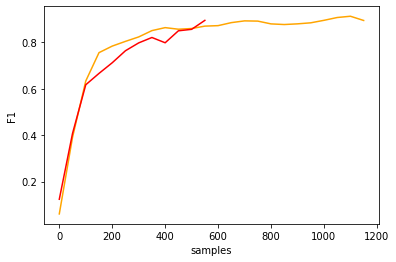

In [128]:
len_ap = len(appliances_4)
#plt.plot(np.array(counts_arr_stored_4)[:,1], np.sum(np.array(F1_stored_4),axis=0)/11, '-')
#plt.plot(np.array(counts_arr_stored_4)[:,1], savgol_filter(np.sum(np.array(F1_stored_4),axis=0)/11,5,1), '-',color="orange")
len_ap = len(appliances_5)
#plt.plot(np.array(counts_arr_stored_5)[:,1], np.sum(np.array(F1_stored_5)[:len_ap,:],axis=0)/len_ap, '-')
plt.plot(np.array(counts_arr_stored_5)[:,1], savgol_filter(np.sum(np.array(F1_stored_5)[:len_ap,:],axis=0)/len_ap,3,1), '-',color="orange")
len_ap = len(appliances)
plt.plot(np.array(counts_arr)[:,1], savgol_filter(np.sum(np.array(F1)[:len_ap,:],axis=0)/len_ap,3,1), '-',color="red")
#plt.plot(np.array(counts_arr)[:,1], np.sum(np.array(F1)[:len_ap,:],axis=0)/len_ap, '-')



plt.ylabel("F1")
plt.xlabel("samples")
plt.show()

0 HEKA


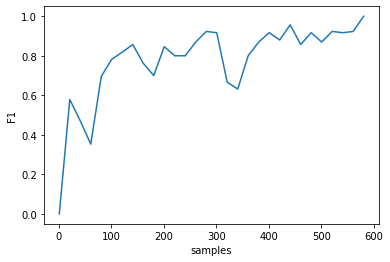

1 fridge/freezer


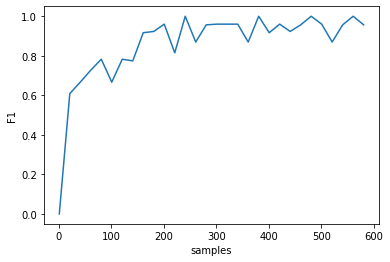

2 HTPC


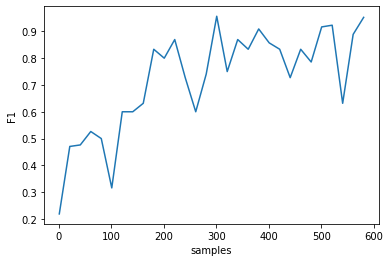

3 boiler


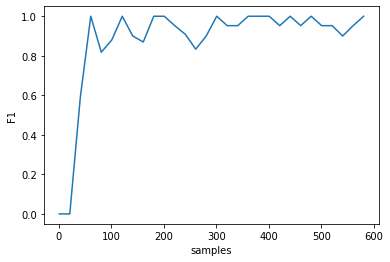

4 computer monitor


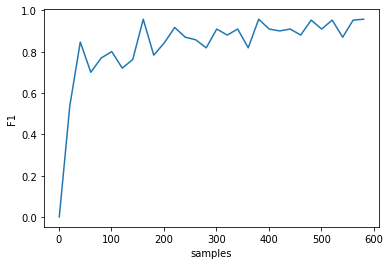

5 desktop computer


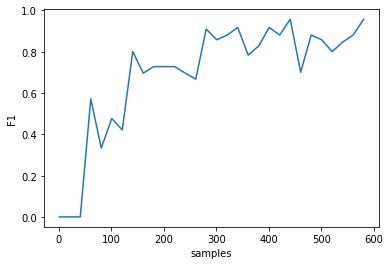

6 dish washer


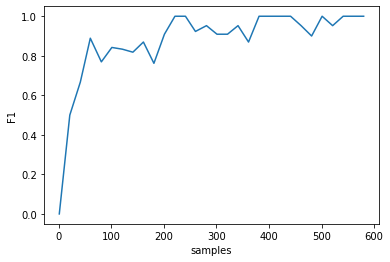

7 laptop computer


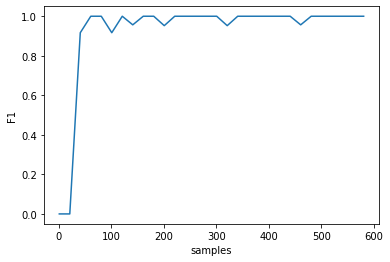

8 light


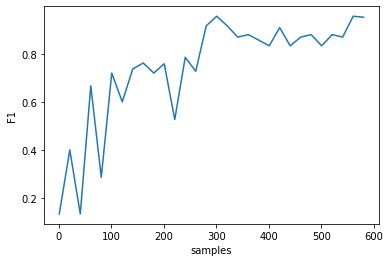

9 microwave


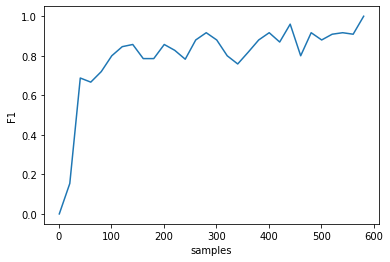

10 server computer


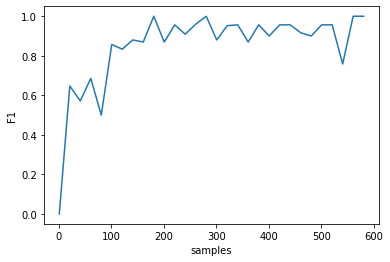

11 television


IndexError: index 11 is out of bounds for axis 0 with size 11

In [30]:
for i,e in enumerate(appliances):
    print(i,e)
    plt.plot(np.array(counts_arr)[:,i], np.array(F1)[i,:], '-')
    plt.ylabel("F1")
    plt.xlabel("samples")
    plt.show()

In [34]:
#automating model generation for various types of models 
i = 0
model_names = [LSTM_3D(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V71(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V72(X_train,num_of_classes,lr = 0.00002)]

for model in model_names:
      
    model_used = model
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 80, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])
    
    path_model_classic = dir_path+"/models/auto_classic7/model_"+str(i)
    model_used.save(path_model_classic)
    i += 1
    
    print("removing model from ram")
    del model_used
    del model
    print("new model")

2021-11-09 16:50:16.282192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-09 16:50:16.304418: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/80


2021-11-09 16:50:17.734429: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-09 16:50:18.490842: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-09 16:50:19.421995: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-09 16:50:20.232182: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2903/2903 - 39s - loss: 2.3346 - accuracy: 0.2877 - val_loss: 1.9897 - val_accuracy: 0.4153
Epoch 2/80
2903/2903 - 33s - loss: 1.8644 - accuracy: 0.4592 - val_loss: 1.7082 - val_accuracy: 0.5411
Epoch 3/80
2903/2903 - 34s - loss: 1.6716 - accuracy: 0.5411 - val_loss: 1.5765 - val_accuracy: 0.5879
Epoch 4/80
2903/2903 - 34s - loss: 1.5497 - accuracy: 0.5827 - val_loss: 1.4817 - val_accuracy: 0.6076
Epoch 5/80
2903/2903 - 34s - loss: 1.4532 - accuracy: 0.6041 - val_loss: 1.3919 - val_accuracy: 0.6353
Epoch 6/80
2903/2903 - 34s - loss: 1.3717 - accuracy: 0.6280 - val_loss: 1.3302 - val_accuracy: 0.6381
Epoch 7/80
2903/2903 - 34s - loss: 1.3036 - accuracy: 0.6392 - val_loss: 1.2670 - val_accuracy: 0.6500
Epoch 8/80
2903/2903 - 34s - loss: 1.2408 - accuracy: 0.6495 - val_loss: 1.1976 - val_accuracy: 0.6577
Epoch 9/80
2903/2903 - 34s - loss: 1.1885 - accuracy: 0.6594 - val_loss: 1.1488 - val_accuracy: 0.6672
Epoch 10/80
2903/2903 - 34s - loss: 1.1281 - accuracy: 0.6718 - val_loss: 1.0910 - v

Epoch 80/80
2903/2903 - 34s - loss: 0.3938 - accuracy: 0.8670 - val_loss: 0.4741 - val_accuracy: 0.8372
227/227 - 3s - loss: 0.4665 - accuracy: 0.8405
Test accuracy:  0.8405457735061646


2021-11-09 17:35:19.102576: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic7/model_0/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic7/model_0/assets


removing model from ram
new model
Epoch 1/80
2903/2903 - 105s - loss: 2.1702 - accuracy: 0.3969 - val_loss: 1.7292 - val_accuracy: 0.5342
Epoch 2/80
2903/2903 - 101s - loss: 1.5119 - accuracy: 0.5639 - val_loss: 1.3327 - val_accuracy: 0.5950
Epoch 3/80
2903/2903 - 101s - loss: 1.2520 - accuracy: 0.6047 - val_loss: 1.1751 - val_accuracy: 0.6191
Epoch 4/80
2903/2903 - 101s - loss: 1.1025 - accuracy: 0.6369 - val_loss: 1.0382 - val_accuracy: 0.6529
Epoch 5/80
2903/2903 - 101s - loss: 0.9934 - accuracy: 0.6700 - val_loss: 0.9514 - val_accuracy: 0.6973
Epoch 6/80
2903/2903 - 101s - loss: 0.9080 - accuracy: 0.7071 - val_loss: 0.8642 - val_accuracy: 0.7159
Epoch 7/80
2903/2903 - 101s - loss: 0.8370 - accuracy: 0.7277 - val_loss: 0.8086 - val_accuracy: 0.7435
Epoch 8/80
2903/2903 - 101s - loss: 0.7856 - accuracy: 0.7472 - val_loss: 0.7853 - val_accuracy: 0.7468
Epoch 9/80
2903/2903 - 101s - loss: 0.7446 - accuracy: 0.7582 - val_loss: 0.7344 - val_accuracy: 0.7588
Epoch 10/80
2903/2903 - 101s -

Epoch 79/80
2903/2903 - 101s - loss: 0.1197 - accuracy: 0.9620 - val_loss: 0.5126 - val_accuracy: 0.8438
Epoch 80/80
2903/2903 - 101s - loss: 0.1190 - accuracy: 0.9611 - val_loss: 0.5107 - val_accuracy: 0.8424
227/227 - 7s - loss: 0.5051 - accuracy: 0.8483
Test accuracy:  0.8482635021209717


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic7/model_1/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic7/model_1/assets


removing model from ram
new model
Epoch 1/80
2903/2903 - 57s - loss: 2.0821 - accuracy: 0.4201 - val_loss: 1.6092 - val_accuracy: 0.5614
Epoch 2/80
2903/2903 - 54s - loss: 1.4010 - accuracy: 0.5890 - val_loss: 1.2382 - val_accuracy: 0.6005
Epoch 3/80
2903/2903 - 54s - loss: 1.1324 - accuracy: 0.6461 - val_loss: 1.0423 - val_accuracy: 0.6668
Epoch 4/80
2903/2903 - 54s - loss: 0.9932 - accuracy: 0.6798 - val_loss: 0.9414 - val_accuracy: 0.6891
Epoch 5/80
2903/2903 - 54s - loss: 0.8986 - accuracy: 0.7003 - val_loss: 0.8978 - val_accuracy: 0.7004
Epoch 6/80
2903/2903 - 54s - loss: 0.8325 - accuracy: 0.7234 - val_loss: 0.8098 - val_accuracy: 0.7388
Epoch 7/80
2903/2903 - 54s - loss: 0.7709 - accuracy: 0.7466 - val_loss: 0.7549 - val_accuracy: 0.7528
Epoch 8/80
2903/2903 - 54s - loss: 0.7235 - accuracy: 0.7629 - val_loss: 0.7419 - val_accuracy: 0.7573
Epoch 9/80
2903/2903 - 55s - loss: 0.6823 - accuracy: 0.7772 - val_loss: 0.6890 - val_accuracy: 0.7728
Epoch 10/80
2903/2903 - 54s - loss: 0.6

Epoch 80/80
2903/2903 - 54s - loss: 0.0624 - accuracy: 0.9792 - val_loss: 0.5818 - val_accuracy: 0.8329
227/227 - 4s - loss: 0.5808 - accuracy: 0.8360
Test accuracy:  0.8359978199005127


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic7/model_2/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic7/model_2/assets


removing model from ram
new model


In [33]:
 #automating model generation for various types of models 
i = 0
model_names = [LSTM_3D(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V61(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V62(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V63(X_train,num_of_classes,lr = 0.00002),LSTM_3D_V64(X_train,num_of_classes,lr = 0.00002)]

for model in model_names:
      
    model_used = model
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 80, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])
    
    path_model_classic = dir_path+"/models/auto_classic6/model_"+str(i)
    model_used.save(path_model_classic)
    i += 1
    
    print("removing model from ram")
    del model_used
    del model
    print("new model")

# KFOLD

In [ ]:
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=42)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# y_train[0]

#y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

skf = StratifiedKFold(n_splits=5,shuffle=False)
print("num of splits:",skf.get_n_splits(data))

for train_index, test_index in skf.split(data, labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
#     train_l = []
#     test_l = []
    
#     for n in range(num_of_classes):
#         train_l.append(len(y_train[y_train==n]))
#         test_l.append(len(y_test[y_test==n]))
    
#     print('>Train:', (train_l),"all",sum(train_l))
#     print('>test:', (test_l),"all",sum(test_l))


    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    
    
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 1)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    
    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    

# Testing LSTM

In [ ]:
#User LSTM_Dense2 to change parameters of different models so that you live lstm34 intact. Otherwise the same as upper training method

model = LSTM_Dense2(X_train,num_of_classes,lr = 0.001)
print(model.summary())
model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 20, verbose = 2)
results = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

In [ ]:
print('Test accuracy: ', results[1])
print("Loss: "f"{results[0]}")
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=appliances))

#CODE DUMP

In [ ]:
## test dependecy of number of samples to performace calculates F1 score for every device (VERSION 1)

#define prec, recall and F1 for each class
prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

#counts arr

counts_arr_main = []
#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0



for i,a in enumerate(appliances):
    num_samples = np.where(labels == i)[0].shape[0]
    number_of_points = 30
    step_size = num_samples/number_of_points
    size_arr = range(5,num_samples,int(step_size))
    print(a,i,num_samples,len(list(size_arr)))
    
    
    appliance_index = i
    
    #if i > 2:
    #    break
    
    counts_arr = []
    
    for size in size_arr:

        #split all
        print("splitting train size %",size)
        #X_train_2, _, y_train_2, _ = train_test_split(X_train, y_train_not_hot, train_size=percent, random_state=12, stratify=y_train_not_hot)
        #values, counts = np.unique(y_train_2, return_counts=True)

        #split for only one appliance

        #get N random images for one aplliance
        index_selected_appl = []
        while len(index_selected_appl) < size :
            choice = random.choice(np.where(labels == appliance_index)[0])
            if choice in index_selected_appl:
                continue
            else:
                index_selected_appl.append(choice)

        a = np.array(index_selected_appl)
        print("instances in array",a.shape)
        print("unique instances",np.unique(a).shape)

        #get indexes from appliances that is not selected
        index_all_other_appl = np.where(labels != appliance_index)[0]
        #append all appliances and n selected indexes
        index_merged = np.append(index_all_other_appl,np.array(index_selected_appl))
        #use indexes to select data
        data2 = data[index_merged]
        labels2 = labels[index_merged]

        X_train, X_test, y_train, y_test = train_test_split(data2, labels2, test_size=.2, random_state=42,stratify=labels2)

        values, counts = np.unique(y_train, return_counts=True)#[index_merged]

        print("appending counts :",counts)
        counts_arr.append(counts[appliance_index])

        y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

        #reset model and compile it again
        model.trainable = False
        base_output = model.layers[-2].output
        #hidden4 = Dense(64, activation='softmax')(base_output)
        hidden3 = Dense(32, activation='softmax')(base_output)
        hidden2 = Dense(16, activation='softmax')(hidden3)
        hidden = Dense(num_of_classes, activation='softmax')(hidden2)

        model2 = keras.models.Model(model.inputs, hidden)
        lr = 0.002
        adam = optimizers.Adam(lr = lr)
        model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        print("xt2",X_train.shape)
        print("yt2",y_train.shape)
        model_used = model2
        model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 30, verbose = 2)
        results = model_used.evaluate(X_test, y_test, verbose = 2)
        print('Test accuracy: ', results[1])

        Y_pred = model_used.predict(X_test, verbose = 2)
        y_pred = np.argmax(Y_pred, axis=1)
        Y_test = np.argmax(y_test, axis=-1)

        #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
        metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

        #del model_used
        #del model2

        #append prec, rec and F1 for each individual class
        for k,j in enumerate(precission):
            if k == appliance_index:
                j.append(metrics[0][k])

        for k,j in enumerate(recall):
            if k == appliance_index:
                j.append(metrics[1][k])

        for k,j in enumerate(F1):
            if k == appliance_index:
                j.append(metrics[2][k])
                
    counts_arr_main.append(counts_arr)

In [ ]:

for i in range(11):
    lena = (len(np.unique(labels))-1)
    data = data[np.where(labels != lena)]
    labels = labels[np.where(labels != lena)]
    print("removed: ", appliances[lena])
    #Convert classes to onehot encoding
    # manualy_selected_appliances= ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
    num_of_classes = len(np.unique(labels)) # 
    print(appliances)
    print(num_of_classes)

    y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

    #Split data on training and testing datasets

    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    y_train[0]

    model = LSTM_3D_V64(X_train,num_of_classes,lr = 0.00002) #00

    model_used = model

    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 100, verbose = 2,callbacks=ClearMemory())
    results = model_used.evaluate(X_test, y_test, verbose = 2)

    path_model_classic = dir_path+"/models/refit/randomOut/model"+i
    model_used.save(path_model_classic)

In [24]:
num_classes_loop = len(np.unique(labels))

#model0 = no washer dryer
for i in range(num_classes_loop):
    lena = (len(np.unique(labels))-1)
    data = data[np.where(labels != lena)]
    labels = labels[np.where(labels != lena)]
    print("removed: ", appliances[lena],"i",i+2)
    print("shape daa",data.shape,"label shape",labels.shape,"uniq",np.unique(labels))
    path_model_classic = dir_path+"/models/refit/randomOut/model"+str(i+2)
    print("path", path_model_classic)
    
    num_of_classes = len(np.unique(labels))
    y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)
    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    y_train[0]
    
    model = LSTM_3D_V64(X_train,num_of_classes,lr = 0.00002) #00

    model_used = model

    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 100, verbose = 2,callbacks=ClearMemory())
    results = model_used.evaluate(X_test, y_test, verbose = 2)

    
    model_used.save(path_model_classic)
    
    del model_used
    del model
    
    X_train = 0
    X_test = 0
    y_train = 0
    y_test = 0

removed:  tumble dryer i 2
shape daa (26600, 5, 100, 100, 1) label shape (26600,) uniq [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
path /workspace/notebooks/models/refit/randomOut/model2
(21280, 5, 100, 100, 1)
(21280, 12)
(5320, 5, 100, 100, 1)
(5320, 12)


2021-11-07 19:26:07.619755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-07 19:26:07.620541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-11-07 19:26:07.620843: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-07 19:26:08.477195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-07 19:26:08.477228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-07 19:26:08.477252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-07 19:26:08.478454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Epoch 1/100


2021-11-07 19:26:13.425295: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-11-07 19:26:14.221679: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-11-07 19:26:15.144541: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-11-07 19:26:15.966343: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2128/2128 - 70s - loss: 2.0813 - accuracy: 0.3539 - val_loss: 1.7623 - val_accuracy: 0.5139
Epoch 2/100
2128/2128 - 63s - loss: 1.4660 - accuracy: 0.5437 - val_loss: 1.2386 - val_accuracy: 0.6093
Epoch 3/100
2128/2128 - 63s - loss: 1.1590 - accuracy: 0.6275 - val_loss: 1.0474 - val_accuracy: 0.6727
Epoch 4/100
2128/2128 - 63s - loss: 1.0010 - accuracy: 0.6708 - val_loss: 0.9140 - val_accuracy: 0.6981
Epoch 5/100
2128/2128 - 63s - loss: 0.9055 - accuracy: 0.6963 - val_loss: 0.8346 - val_accuracy: 0.7129
Epoch 6/100
2128/2128 - 63s - loss: 0.8403 - accuracy: 0.7151 - val_loss: 0.7748 - val_accuracy: 0.7425
Epoch 7/100
2128/2128 - 63s - loss: 0.7890 - accuracy: 0.7324 - val_loss: 0.7458 - val_accuracy: 0.7465
Epoch 8/100
2128/2128 - 63s - loss: 0.7413 - accuracy: 0.7454 - val_loss: 0.7061 - val_accuracy: 0.7596
Epoch 9/100
2128/2128 - 63s - loss: 0.6984 - accuracy: 0.7600 - val_loss: 0.6673 - val_accuracy: 0.7709
Epoch 10/100
2128/2128 - 64s - loss: 0.6625 - accuracy: 0.7727 - val_loss: 0

Epoch 80/100
2128/2128 - 64s - loss: 0.0752 - accuracy: 0.9788 - val_loss: 0.4461 - val_accuracy: 0.8705
Epoch 81/100
2128/2128 - 64s - loss: 0.0769 - accuracy: 0.9781 - val_loss: 0.4550 - val_accuracy: 0.8682
Epoch 82/100
2128/2128 - 64s - loss: 0.0737 - accuracy: 0.9785 - val_loss: 0.4504 - val_accuracy: 0.8717
Epoch 83/100
2128/2128 - 64s - loss: 0.0704 - accuracy: 0.9802 - val_loss: 0.4505 - val_accuracy: 0.8715
Epoch 84/100
2128/2128 - 64s - loss: 0.0860 - accuracy: 0.9747 - val_loss: 0.4603 - val_accuracy: 0.8738
Epoch 85/100
2128/2128 - 64s - loss: 0.0636 - accuracy: 0.9831 - val_loss: 0.4463 - val_accuracy: 0.8743
Epoch 86/100
2128/2128 - 64s - loss: 0.0641 - accuracy: 0.9829 - val_loss: 0.4739 - val_accuracy: 0.8680
Epoch 87/100
2128/2128 - 64s - loss: 0.0668 - accuracy: 0.9817 - val_loss: 0.4580 - val_accuracy: 0.8717
Epoch 88/100
2128/2128 - 64s - loss: 0.0611 - accuracy: 0.9831 - val_loss: 0.4663 - val_accuracy: 0.8672
Epoch 89/100
2128/2128 - 64s - loss: 0.0621 - accuracy:

2021-11-07 21:12:30.459030: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model2/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model2/assets


removed:  television i 3
shape daa (22468, 5, 100, 100, 1) label shape (22468,) uniq [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
path /workspace/notebooks/models/refit/randomOut/model3
(17974, 5, 100, 100, 1)
(17974, 11)
(4494, 5, 100, 100, 1)
(4494, 11)
Epoch 1/100
1798/1798 - 66s - loss: 1.9441 - accuracy: 0.3771 - val_loss: 1.6057 - val_accuracy: 0.5850
Epoch 2/100
1798/1798 - 63s - loss: 1.3612 - accuracy: 0.6194 - val_loss: 1.1372 - val_accuracy: 0.6907
Epoch 3/100
1798/1798 - 63s - loss: 1.0592 - accuracy: 0.7128 - val_loss: 0.9252 - val_accuracy: 0.7377
Epoch 4/100
1798/1798 - 63s - loss: 0.8718 - accuracy: 0.7619 - val_loss: 0.8841 - val_accuracy: 0.7444
Epoch 5/100
1798/1798 - 63s - loss: 0.7553 - accuracy: 0.7802 - val_loss: 0.6923 - val_accuracy: 0.7928
Epoch 6/100
1798/1798 - 63s - loss: 0.6671 - accuracy: 0.7980 - val_loss: 0.6243 - val_accuracy: 0.7997
Epoch 7/100
1798/1798 - 63s - loss: 0.6082 - accuracy: 0.8116 - val_loss: 0.5660 - val_accuracy: 0.8145
Epoch 8/100
179

Epoch 77/100
1798/1798 - 63s - loss: 0.0487 - accuracy: 0.9881 - val_loss: 0.3237 - val_accuracy: 0.9107
Epoch 78/100
1798/1798 - 63s - loss: 0.0520 - accuracy: 0.9853 - val_loss: 0.3302 - val_accuracy: 0.9129
Epoch 79/100
1798/1798 - 63s - loss: 0.0488 - accuracy: 0.9875 - val_loss: 0.3113 - val_accuracy: 0.9132
Epoch 80/100
1798/1798 - 63s - loss: 0.0471 - accuracy: 0.9878 - val_loss: 0.3232 - val_accuracy: 0.9115
Epoch 81/100
1798/1798 - 63s - loss: 0.0437 - accuracy: 0.9898 - val_loss: 0.3287 - val_accuracy: 0.9110
Epoch 82/100
1798/1798 - 63s - loss: 0.0513 - accuracy: 0.9862 - val_loss: 0.3267 - val_accuracy: 0.9110
Epoch 83/100
1798/1798 - 63s - loss: 0.0422 - accuracy: 0.9895 - val_loss: 0.3182 - val_accuracy: 0.9149
Epoch 84/100
1798/1798 - 63s - loss: 0.0381 - accuracy: 0.9909 - val_loss: 0.3409 - val_accuracy: 0.9076
Epoch 85/100
1798/1798 - 63s - loss: 0.0408 - accuracy: 0.9895 - val_loss: 0.3929 - val_accuracy: 0.8985
Epoch 86/100
1798/1798 - 63s - loss: 0.0437 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model3/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model3/assets


removed:  pond pump i 4
shape daa (21468, 5, 100, 100, 1) label shape (21468,) uniq [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
path /workspace/notebooks/models/refit/randomOut/model4
(17174, 5, 100, 100, 1)
(17174, 10)
(4294, 5, 100, 100, 1)
(4294, 10)
Epoch 1/100
1718/1718 - 63s - loss: 1.8360 - accuracy: 0.4515 - val_loss: 1.5225 - val_accuracy: 0.6178
Epoch 2/100
1718/1718 - 60s - loss: 1.3036 - accuracy: 0.6883 - val_loss: 1.0409 - val_accuracy: 0.7365
Epoch 3/100
1718/1718 - 60s - loss: 0.9706 - accuracy: 0.7347 - val_loss: 0.8519 - val_accuracy: 0.7531
Epoch 4/100
1718/1718 - 60s - loss: 0.8144 - accuracy: 0.7569 - val_loss: 0.7547 - val_accuracy: 0.7619
Epoch 5/100
1718/1718 - 60s - loss: 0.7077 - accuracy: 0.7719 - val_loss: 0.6372 - val_accuracy: 0.7959
Epoch 6/100
1718/1718 - 60s - loss: 0.6353 - accuracy: 0.7960 - val_loss: 0.6046 - val_accuracy: 0.8017
Epoch 7/100
1718/1718 - 60s - loss: 0.5809 - accuracy: 0.8188 - val_loss: 0.5963 - val_accuracy: 0.8064
Epoch 8/100
1718/1718 - 60s - 

Epoch 77/100
1718/1718 - 60s - loss: 0.0450 - accuracy: 0.9878 - val_loss: 0.2745 - val_accuracy: 0.9223
Epoch 78/100
1718/1718 - 60s - loss: 0.0513 - accuracy: 0.9849 - val_loss: 0.2810 - val_accuracy: 0.9194
Epoch 79/100
1718/1718 - 60s - loss: 0.0534 - accuracy: 0.9839 - val_loss: 0.2838 - val_accuracy: 0.9205
Epoch 80/100
1718/1718 - 60s - loss: 0.0430 - accuracy: 0.9884 - val_loss: 0.2934 - val_accuracy: 0.9214
Epoch 81/100
1718/1718 - 60s - loss: 0.0566 - accuracy: 0.9833 - val_loss: 0.3058 - val_accuracy: 0.9106
Epoch 82/100
1718/1718 - 60s - loss: 0.0414 - accuracy: 0.9892 - val_loss: 0.2985 - val_accuracy: 0.9205
Epoch 83/100
1718/1718 - 60s - loss: 0.0509 - accuracy: 0.9851 - val_loss: 0.2961 - val_accuracy: 0.9162
Epoch 84/100
1718/1718 - 60s - loss: 0.0424 - accuracy: 0.9881 - val_loss: 0.2948 - val_accuracy: 0.9188
Epoch 85/100
1718/1718 - 60s - loss: 0.0407 - accuracy: 0.9890 - val_loss: 0.3296 - val_accuracy: 0.9144
Epoch 86/100
1718/1718 - 60s - loss: 0.0379 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model4/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model4/assets


removed:  food processor i 5
shape daa (20591, 5, 100, 100, 1) label shape (20591,) uniq [0. 1. 2. 3. 4. 5. 6. 7. 8.]
path /workspace/notebooks/models/refit/randomOut/model5
(16472, 5, 100, 100, 1)
(16472, 9)
(4119, 5, 100, 100, 1)
(4119, 9)
Epoch 1/100
1648/1648 - 60s - loss: 1.6762 - accuracy: 0.4706 - val_loss: 1.3246 - val_accuracy: 0.6416
Epoch 2/100
1648/1648 - 57s - loss: 1.1019 - accuracy: 0.7183 - val_loss: 0.8260 - val_accuracy: 0.7709
Epoch 3/100
1648/1648 - 57s - loss: 0.7615 - accuracy: 0.7844 - val_loss: 0.6672 - val_accuracy: 0.8030
Epoch 4/100
1648/1648 - 57s - loss: 0.6416 - accuracy: 0.8102 - val_loss: 0.5883 - val_accuracy: 0.8158
Epoch 5/100
1648/1648 - 57s - loss: 0.5655 - accuracy: 0.8268 - val_loss: 0.5394 - val_accuracy: 0.8255
Epoch 6/100
1648/1648 - 57s - loss: 0.5133 - accuracy: 0.8365 - val_loss: 0.5186 - val_accuracy: 0.8319
Epoch 7/100
1648/1648 - 57s - loss: 0.4737 - accuracy: 0.8461 - val_loss: 0.4834 - val_accuracy: 0.8373
Epoch 8/100
1648/1648 - 57s - 

Epoch 77/100
1648/1648 - 57s - loss: 0.0335 - accuracy: 0.9902 - val_loss: 0.3350 - val_accuracy: 0.9123
Epoch 78/100
1648/1648 - 57s - loss: 0.0322 - accuracy: 0.9913 - val_loss: 0.3208 - val_accuracy: 0.9162
Epoch 79/100
1648/1648 - 57s - loss: 0.0252 - accuracy: 0.9939 - val_loss: 0.3282 - val_accuracy: 0.9159
Epoch 80/100
1648/1648 - 57s - loss: 0.0290 - accuracy: 0.9920 - val_loss: 0.3212 - val_accuracy: 0.9138
Epoch 81/100
1648/1648 - 57s - loss: 0.0253 - accuracy: 0.9934 - val_loss: 0.3243 - val_accuracy: 0.9156
Epoch 82/100
1648/1648 - 57s - loss: 0.0279 - accuracy: 0.9928 - val_loss: 0.3428 - val_accuracy: 0.9117
Epoch 83/100
1648/1648 - 57s - loss: 0.0279 - accuracy: 0.9923 - val_loss: 0.3275 - val_accuracy: 0.9171
Epoch 84/100
1648/1648 - 57s - loss: 0.0265 - accuracy: 0.9931 - val_loss: 0.3468 - val_accuracy: 0.9120
Epoch 85/100
1648/1648 - 57s - loss: 0.0226 - accuracy: 0.9940 - val_loss: 0.3248 - val_accuracy: 0.9129
Epoch 86/100
1648/1648 - 57s - loss: 0.0273 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model5/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model5/assets


removed:  electric space heater i 6
shape daa (19657, 5, 100, 100, 1) label shape (19657,) uniq [0. 1. 2. 3. 4. 5. 6. 7.]
path /workspace/notebooks/models/refit/randomOut/model6
(15725, 5, 100, 100, 1)
(15725, 8)
(3932, 5, 100, 100, 1)
(3932, 8)
Epoch 1/100
1573/1573 - 57s - loss: 1.6149 - accuracy: 0.5037 - val_loss: 1.2767 - val_accuracy: 0.6642
Epoch 2/100
1573/1573 - 55s - loss: 1.0817 - accuracy: 0.7193 - val_loss: 0.8375 - val_accuracy: 0.7955
Epoch 3/100
1573/1573 - 55s - loss: 0.7737 - accuracy: 0.7909 - val_loss: 0.6347 - val_accuracy: 0.8286
Epoch 4/100
1573/1573 - 55s - loss: 0.6242 - accuracy: 0.8232 - val_loss: 0.5951 - val_accuracy: 0.8210
Epoch 5/100
1573/1573 - 55s - loss: 0.5313 - accuracy: 0.8415 - val_loss: 0.4801 - val_accuracy: 0.8483
Epoch 6/100
1573/1573 - 55s - loss: 0.4781 - accuracy: 0.8483 - val_loss: 0.4212 - val_accuracy: 0.8649
Epoch 7/100
1573/1573 - 55s - loss: 0.4337 - accuracy: 0.8575 - val_loss: 0.4076 - val_accuracy: 0.8633
Epoch 8/100
1573/1573 - 55

Epoch 77/100
1573/1573 - 55s - loss: 0.0279 - accuracy: 0.9932 - val_loss: 0.2487 - val_accuracy: 0.9285
Epoch 78/100
1573/1573 - 55s - loss: 0.0297 - accuracy: 0.9922 - val_loss: 0.2401 - val_accuracy: 0.9269
Epoch 79/100
1573/1573 - 55s - loss: 0.0367 - accuracy: 0.9892 - val_loss: 0.2553 - val_accuracy: 0.9183
Epoch 80/100
1573/1573 - 55s - loss: 0.0260 - accuracy: 0.9932 - val_loss: 0.2430 - val_accuracy: 0.9275
Epoch 81/100
1573/1573 - 55s - loss: 0.0276 - accuracy: 0.9922 - val_loss: 0.2548 - val_accuracy: 0.9269
Epoch 82/100
1573/1573 - 55s - loss: 0.0289 - accuracy: 0.9923 - val_loss: 0.2498 - val_accuracy: 0.9186
Epoch 83/100
1573/1573 - 55s - loss: 0.0233 - accuracy: 0.9938 - val_loss: 0.2709 - val_accuracy: 0.9262
Epoch 84/100
1573/1573 - 55s - loss: 0.0240 - accuracy: 0.9932 - val_loss: 0.2836 - val_accuracy: 0.9176
Epoch 85/100
1573/1573 - 55s - loss: 0.0263 - accuracy: 0.9928 - val_loss: 0.2536 - val_accuracy: 0.9281
Epoch 86/100
1573/1573 - 55s - loss: 0.0224 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model6/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model6/assets


removed:  dish washer i 7
shape daa (15741, 5, 100, 100, 1) label shape (15741,) uniq [0. 1. 2. 3. 4. 5. 6.]
path /workspace/notebooks/models/refit/randomOut/model7
(12592, 5, 100, 100, 1)
(12592, 7)
(3149, 5, 100, 100, 1)
(3149, 7)
Epoch 1/100
1260/1260 - 47s - loss: 1.4377 - accuracy: 0.5341 - val_loss: 1.1547 - val_accuracy: 0.7293
Epoch 2/100
1260/1260 - 44s - loss: 0.9878 - accuracy: 0.7568 - val_loss: 0.8001 - val_accuracy: 0.7856
Epoch 3/100
1260/1260 - 44s - loss: 0.7413 - accuracy: 0.7859 - val_loss: 0.6526 - val_accuracy: 0.8067
Epoch 4/100
1260/1260 - 44s - loss: 0.6379 - accuracy: 0.8031 - val_loss: 0.5829 - val_accuracy: 0.8178
Epoch 5/100
1260/1260 - 44s - loss: 0.5655 - accuracy: 0.8116 - val_loss: 0.5372 - val_accuracy: 0.8178
Epoch 6/100
1260/1260 - 44s - loss: 0.5169 - accuracy: 0.8186 - val_loss: 0.5174 - val_accuracy: 0.8241
Epoch 7/100
1260/1260 - 44s - loss: 0.4801 - accuracy: 0.8314 - val_loss: 0.4328 - val_accuracy: 0.8523
Epoch 8/100
1260/1260 - 44s - loss: 0.4

Epoch 77/100
1260/1260 - 44s - loss: 0.0338 - accuracy: 0.9912 - val_loss: 0.3003 - val_accuracy: 0.9103
Epoch 78/100
1260/1260 - 44s - loss: 0.0332 - accuracy: 0.9908 - val_loss: 0.3041 - val_accuracy: 0.9131
Epoch 79/100
1260/1260 - 44s - loss: 0.0382 - accuracy: 0.9910 - val_loss: 0.3050 - val_accuracy: 0.9123
Epoch 80/100
1260/1260 - 44s - loss: 0.0313 - accuracy: 0.9909 - val_loss: 0.2901 - val_accuracy: 0.9182
Epoch 81/100
1260/1260 - 44s - loss: 0.0333 - accuracy: 0.9908 - val_loss: 0.3227 - val_accuracy: 0.9115
Epoch 82/100
1260/1260 - 44s - loss: 0.0264 - accuracy: 0.9927 - val_loss: 0.3294 - val_accuracy: 0.9146
Epoch 83/100
1260/1260 - 44s - loss: 0.0259 - accuracy: 0.9930 - val_loss: 0.3034 - val_accuracy: 0.9131
Epoch 84/100
1260/1260 - 44s - loss: 0.0345 - accuracy: 0.9895 - val_loss: 0.3162 - val_accuracy: 0.9186
Epoch 85/100
1260/1260 - 44s - loss: 0.0303 - accuracy: 0.9915 - val_loss: 0.3272 - val_accuracy: 0.9131
Epoch 86/100
1260/1260 - 44s - loss: 0.0263 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model7/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model7/assets


removed:  dehumidifier i 8
shape daa (15128, 5, 100, 100, 1) label shape (15128,) uniq [0. 1. 2. 3. 4. 5.]
path /workspace/notebooks/models/refit/randomOut/model8
(12102, 5, 100, 100, 1)
(12102, 6)
(3026, 5, 100, 100, 1)
(3026, 6)
Epoch 1/100
1211/1211 - 45s - loss: 1.2674 - accuracy: 0.6024 - val_loss: 0.9978 - val_accuracy: 0.7423
Epoch 2/100
1211/1211 - 42s - loss: 0.7544 - accuracy: 0.7961 - val_loss: 0.6203 - val_accuracy: 0.8038
Epoch 3/100
1211/1211 - 42s - loss: 0.5810 - accuracy: 0.8171 - val_loss: 0.5233 - val_accuracy: 0.8273
Epoch 4/100
1211/1211 - 42s - loss: 0.4957 - accuracy: 0.8308 - val_loss: 0.6030 - val_accuracy: 0.7935
Epoch 5/100
1211/1211 - 42s - loss: 0.4478 - accuracy: 0.8402 - val_loss: 0.4169 - val_accuracy: 0.8435
Epoch 6/100
1211/1211 - 42s - loss: 0.4100 - accuracy: 0.8512 - val_loss: 0.3936 - val_accuracy: 0.8426
Epoch 7/100
1211/1211 - 42s - loss: 0.3865 - accuracy: 0.8558 - val_loss: 0.3766 - val_accuracy: 0.8579
Epoch 8/100
1211/1211 - 42s - loss: 0.361

Epoch 77/100
1211/1211 - 42s - loss: 0.0294 - accuracy: 0.9917 - val_loss: 0.2995 - val_accuracy: 0.9104
Epoch 78/100
1211/1211 - 42s - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.2982 - val_accuracy: 0.9133
Epoch 79/100
1211/1211 - 42s - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.2883 - val_accuracy: 0.9141
Epoch 80/100
1211/1211 - 42s - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.2942 - val_accuracy: 0.9124
Epoch 81/100
1211/1211 - 42s - loss: 0.0277 - accuracy: 0.9912 - val_loss: 0.3019 - val_accuracy: 0.9120
Epoch 82/100
1211/1211 - 42s - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.3247 - val_accuracy: 0.9108
Epoch 83/100
1211/1211 - 42s - loss: 0.0139 - accuracy: 0.9964 - val_loss: 0.3241 - val_accuracy: 0.9116
Epoch 84/100
1211/1211 - 42s - loss: 0.0344 - accuracy: 0.9878 - val_loss: 0.2995 - val_accuracy: 0.9137
Epoch 85/100
1211/1211 - 42s - loss: 0.0183 - accuracy: 0.9957 - val_loss: 0.3006 - val_accuracy: 0.9141
Epoch 86/100
1211/1211 - 42s - loss: 0.0189 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model8/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model8/assets


removed:  computer i 9
shape daa (10723, 5, 100, 100, 1) label shape (10723,) uniq [0. 1. 2. 3. 4.]
path /workspace/notebooks/models/refit/randomOut/model9
(8578, 5, 100, 100, 1)
(8578, 5)
(2145, 5, 100, 100, 1)
(2145, 5)
Epoch 1/100
858/858 - 33s - loss: 1.1636 - accuracy: 0.6743 - val_loss: 0.8692 - val_accuracy: 0.8497
Epoch 2/100
858/858 - 30s - loss: 0.6936 - accuracy: 0.8748 - val_loss: 0.4849 - val_accuracy: 0.9184
Epoch 3/100
858/858 - 30s - loss: 0.4107 - accuracy: 0.9111 - val_loss: 0.3393 - val_accuracy: 0.9178
Epoch 4/100
858/858 - 30s - loss: 0.3202 - accuracy: 0.9161 - val_loss: 0.2994 - val_accuracy: 0.9196
Epoch 5/100
858/858 - 30s - loss: 0.2662 - accuracy: 0.9238 - val_loss: 0.2525 - val_accuracy: 0.9237
Epoch 6/100
858/858 - 30s - loss: 0.2395 - accuracy: 0.9255 - val_loss: 0.2220 - val_accuracy: 0.9365
Epoch 7/100
858/858 - 30s - loss: 0.2093 - accuracy: 0.9360 - val_loss: 0.2081 - val_accuracy: 0.9406
Epoch 8/100
858/858 - 30s - loss: 0.1881 - accuracy: 0.9452 - va

Epoch 79/100
858/858 - 30s - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.1212 - val_accuracy: 0.9738
Epoch 80/100
858/858 - 30s - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.1024 - val_accuracy: 0.9761
Epoch 81/100
858/858 - 30s - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.1046 - val_accuracy: 0.9767
Epoch 82/100
858/858 - 30s - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0823 - val_accuracy: 0.9819
Epoch 83/100
858/858 - 30s - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0972 - val_accuracy: 0.9790
Epoch 84/100
858/858 - 30s - loss: 0.0021 - accuracy: 0.9999 - val_loss: 0.0915 - val_accuracy: 0.9808
Epoch 85/100
858/858 - 30s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1201 - val_accuracy: 0.9668
Epoch 86/100
858/858 - 30s - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.1017 - val_accuracy: 0.9749
Epoch 87/100
858/858 - 30s - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0990 - val_accuracy: 0.9790
Epoch 88/100
858/858 - 30s - loss: 0.0037 - accuracy: 0.9996 - val_loss: 

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model9/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model9/assets


removed:  broadband router i 10
shape daa (9723, 5, 100, 100, 1) label shape (9723,) uniq [0. 1. 2. 3.]
path /workspace/notebooks/models/refit/randomOut/model10
(7778, 5, 100, 100, 1)
(7778, 4)
(1945, 5, 100, 100, 1)
(1945, 4)
Epoch 1/100
778/778 - 30s - loss: 0.8484 - accuracy: 0.7801 - val_loss: 0.4487 - val_accuracy: 0.9409
Epoch 2/100
778/778 - 27s - loss: 0.3135 - accuracy: 0.9362 - val_loss: 0.2081 - val_accuracy: 0.9537
Epoch 3/100
778/778 - 27s - loss: 0.1927 - accuracy: 0.9560 - val_loss: 0.1532 - val_accuracy: 0.9685
Epoch 4/100
778/778 - 27s - loss: 0.1541 - accuracy: 0.9646 - val_loss: 0.1478 - val_accuracy: 0.9608
Epoch 5/100
778/778 - 27s - loss: 0.1350 - accuracy: 0.9683 - val_loss: 0.1647 - val_accuracy: 0.9602
Epoch 6/100
778/778 - 27s - loss: 0.1121 - accuracy: 0.9738 - val_loss: 0.1072 - val_accuracy: 0.9704
Epoch 7/100
778/778 - 27s - loss: 0.1049 - accuracy: 0.9740 - val_loss: 0.0887 - val_accuracy: 0.9794
Epoch 8/100
778/778 - 27s - loss: 0.0970 - accuracy: 0.9744

Epoch 79/100
778/778 - 27s - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0551 - val_accuracy: 0.9865
Epoch 80/100
778/778 - 27s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0560 - val_accuracy: 0.9846
Epoch 81/100
778/778 - 27s - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.0617 - val_accuracy: 0.9852
Epoch 82/100
778/778 - 27s - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0565 - val_accuracy: 0.9846
Epoch 83/100
778/778 - 27s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0537 - val_accuracy: 0.9859
Epoch 84/100
778/778 - 27s - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.0584 - val_accuracy: 0.9852
Epoch 85/100
778/778 - 27s - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0567 - val_accuracy: 0.9846
Epoch 86/100
778/778 - 27s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0579 - val_accuracy: 0.9839
Epoch 87/100
778/778 - 27s - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0967 - val_accuracy: 0.9801
Epoch 88/100
778/778 - 27s - loss: 0.0038 - accuracy: 0.9990 - val_loss: 

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model10/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model10/assets


removed:  breadmaker i 11
shape daa (9405, 5, 100, 100, 1) label shape (9405,) uniq [0. 1. 2.]
path /workspace/notebooks/models/refit/randomOut/model11
(7524, 5, 100, 100, 1)
(7524, 3)
(1881, 5, 100, 100, 1)
(1881, 3)
Epoch 1/100
753/753 - 29s - loss: 0.6692 - accuracy: 0.7222 - val_loss: 0.4579 - val_accuracy: 0.9415
Epoch 2/100
753/753 - 26s - loss: 0.2737 - accuracy: 0.9590 - val_loss: 0.1415 - val_accuracy: 0.9781
Epoch 3/100
753/753 - 26s - loss: 0.1484 - accuracy: 0.9681 - val_loss: 0.1065 - val_accuracy: 0.9821
Epoch 4/100
753/753 - 26s - loss: 0.1151 - accuracy: 0.9734 - val_loss: 0.0928 - val_accuracy: 0.9814
Epoch 5/100
753/753 - 26s - loss: 0.1004 - accuracy: 0.9762 - val_loss: 0.0869 - val_accuracy: 0.9767
Epoch 6/100
753/753 - 26s - loss: 0.0872 - accuracy: 0.9781 - val_loss: 0.0667 - val_accuracy: 0.9847
Epoch 7/100
753/753 - 26s - loss: 0.0826 - accuracy: 0.9762 - val_loss: 0.0613 - val_accuracy: 0.9860
Epoch 8/100
753/753 - 26s - loss: 0.0735 - accuracy: 0.9791 - val_lo

Epoch 79/100
753/753 - 26s - loss: 0.0050 - accuracy: 0.9982 - val_loss: 0.0625 - val_accuracy: 0.9834
Epoch 80/100
753/753 - 26s - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0523 - val_accuracy: 0.9874
Epoch 81/100
753/753 - 26s - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0542 - val_accuracy: 0.9874
Epoch 82/100
753/753 - 26s - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0515 - val_accuracy: 0.9887
Epoch 83/100
753/753 - 26s - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0505 - val_accuracy: 0.9854
Epoch 84/100
753/753 - 26s - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.1012 - val_accuracy: 0.9794
Epoch 85/100
753/753 - 26s - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.0548 - val_accuracy: 0.9874
Epoch 86/100
753/753 - 26s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0644 - val_accuracy: 0.9874
Epoch 87/100
753/753 - 26s - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0482 - val_accuracy: 0.9907
Epoch 88/100
753/753 - 26s - loss: 0.0015 - accuracy: 0.9998 - val_loss: 

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model11/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model11/assets


removed:  audio system i 12
shape daa (7694, 5, 100, 100, 1) label shape (7694,) uniq [0. 1.]
path /workspace/notebooks/models/refit/randomOut/model12
(6155, 5, 100, 100, 1)
(6155, 2)
(1539, 5, 100, 100, 1)
(1539, 2)
Epoch 1/100
616/616 - 24s - loss: 0.3955 - accuracy: 0.9029 - val_loss: 0.1743 - val_accuracy: 0.9764
Epoch 2/100
616/616 - 21s - loss: 0.1251 - accuracy: 0.9734 - val_loss: 0.0971 - val_accuracy: 0.9789
Epoch 3/100
616/616 - 21s - loss: 0.1009 - accuracy: 0.9760 - val_loss: 0.0871 - val_accuracy: 0.9797
Epoch 4/100
616/616 - 21s - loss: 0.0932 - accuracy: 0.9775 - val_loss: 0.1112 - val_accuracy: 0.9805
Epoch 5/100
616/616 - 21s - loss: 0.0869 - accuracy: 0.9773 - val_loss: 0.0739 - val_accuracy: 0.9805
Epoch 6/100
616/616 - 21s - loss: 0.0824 - accuracy: 0.9779 - val_loss: 0.0733 - val_accuracy: 0.9805
Epoch 7/100
616/616 - 21s - loss: 0.0774 - accuracy: 0.9791 - val_loss: 0.0681 - val_accuracy: 0.9805
Epoch 8/100
616/616 - 21s - loss: 0.0716 - accuracy: 0.9785 - val_los

Epoch 79/100
616/616 - 21s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0517 - val_accuracy: 0.9894
Epoch 80/100
616/616 - 21s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0513 - val_accuracy: 0.9894
Epoch 81/100
616/616 - 21s - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0521 - val_accuracy: 0.9886
Epoch 82/100
616/616 - 21s - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0538 - val_accuracy: 0.9870
Epoch 83/100
616/616 - 21s - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0541 - val_accuracy: 0.9870
Epoch 84/100
616/616 - 21s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0566 - val_accuracy: 0.9846
Epoch 85/100
616/616 - 21s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0628 - val_accuracy: 0.9821
Epoch 86/100
616/616 - 21s - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0671 - val_accuracy: 0.9862
Epoch 87/100
616/616 - 21s - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0797 - val_accuracy: 0.9854
Epoch 88/100
616/616 - 21s - loss: 0.0055 - accuracy: 0.9980 - val_loss: 

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model12/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model12/assets


removed:  fridge/freezer i 13
shape daa (2992, 5, 100, 100, 1) label shape (2992,) uniq [0.]
path /workspace/notebooks/models/refit/randomOut/model13
(2393, 5, 100, 100, 1)
(2393, 1)
(599, 5, 100, 100, 1)
(599, 1)
Epoch 1/100
240/240 - 11s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/100
240/240 - 

Epoch 74/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 75/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 76/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 77/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 78/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 79/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 80/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 81/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 82/100
240/240 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 83/1

INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model13/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/refit/randomOut/model13/assets


removed:  HEKA i 14
shape daa (0, 5, 100, 100, 1) label shape (0,) uniq []
path /workspace/notebooks/models/refit/randomOut/model14


ValueError: zero-size array to reduction operation maximum which has no identity